### Time Series Prediction and Spatial Data Clustering on Large Earthquakes

This project made use of a publicly accessible open dataset "Significant Earthquakes, 1965-2016" released by the US Geological Survey, available on Kaggle at: https://www.kaggle.com/usgs/earthquake-database.

It contains over 23,000 major earthquake events with a recorded magnitude of 5.5 or above over the past 50-year period. Predicting earthquakes is an active research topic involving time-series and sequence modelling, and meanwhile a challenging task owing to high uncertainties and complexities of the Earth dynamic systems. Without much emphases on prior geological or earth science knowledge, applying purely data-driven unsupervised feature learning and predictive methods can help recognize spatial and temporal patterns through training sequnece based and time series models.

Layout of this notebook includes:
<ul><li>Spatial Clustering by HDBSCAN
      <ul><li>reasonble to assume or believe there exists a certain extent of homogeneity or pattern within a zone of frequent occurrences</li>
          <li>previewing the spatial distribution could give a preliminary visualization and group dense target regions</li>
          <li>haver-sine distance for representing Earth surface curvature</li></ul></li>
  <li>Time-series based feature extractions and engineering
      <ul><li>creating data of time lags</li>
          <li>differences in time intervals between precedent and subsequent events</li></ul></li>
  <li>Graphical models for making structured predictions to event series
      <ul><li>Hidden Markov Model (HMM)</li>
          <li>Conditional Random Field (CRF)</li>
          <li>Bayesian Network</li>
          <li>Deep Belief Network (DBN) built on stacked Restricted Boltzmann Machine (RBM)</li></ul></li>
  <li>Long-Short Term Memmory (LSTM) network & Gated Recurrent Unit (GRU)</li>
      <ul><li>predicting magnitudes of large earthquakes in future periods</li>
          <li>predicting counts of large earthquakes in future periods</li>
          <li>predicting time intervals until next large earthquakes</li>
          <li>predicting locations for next large earthquakes</ul></li></ul>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

## read the raw data
df = pd.read_csv(F'drive/My Drive/Colab Notebooks/earthquake.csv')

## Cleaning on date attribute: convert string to date format and extract year, month, day
time_arr = [pd.Period(item) for item in np.array(df['Date'])]
df['Date'] = time_arr
df['year'] = df['Date'].apply(lambda x: x.year)
df['month'] = df['Date'].apply(lambda x: x.month)
df['day'] = df['Date'].apply(lambda x: x.day)

In [0]:
df[0:10]

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,year,month,day
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,1965,1,2
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,1965,1,4
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,1965,1,5
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,1965,1,8
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8,1965,1,9
5,1965-01-10,13:36:32,-13.405,166.629,Earthquake,35.0,6.7,1965,1,10
6,1965-01-12,13:32:25,27.357,87.867,Earthquake,20.0,5.9,1965,1,12
7,1965-01-15,23:17:42,-13.309,166.212,Earthquake,35.0,6.0,1965,1,15
8,1965-01-16,11:32:37,-56.452,-27.043,Earthquake,95.0,6.0,1965,1,16
9,1965-01-17,10:43:17,-24.563,178.487,Earthquake,565.0,5.8,1965,1,17


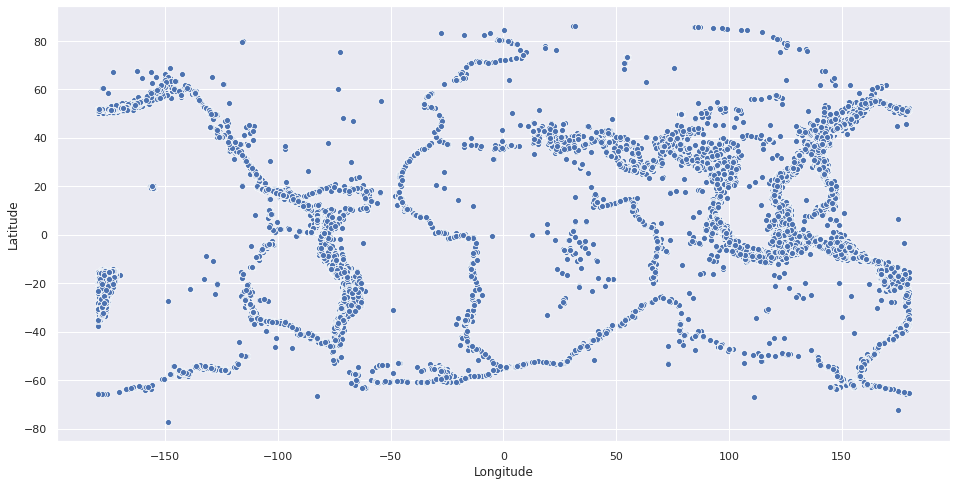

In [0]:
# To plot the geo-location coordinates of earthquake occurrences
coord = np.matrix(df.iloc[:,2:4])
seaborn.set(rc={'figure.figsize':(16.0, 8.0)})
seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2])

#### Spatial Clustering by HDBSCAN:

For unsupervised geo-location feature learning, we might do:
1. Partition all data points into clusters;<br>
   Obtain an earthquake sequence in temporal order by the segmented regions; <br>
   Predict the regions for the subsequent earthquakes.
2. Cluster only the zones of locations of frequent events with noisy points sorted out;<br>
   Aggregate the features for the cluster-specific time series into equally-spaced intervals (monthly / weekly based);<br>
   Predict on the values of the aggregated features for the next t + 1, t + 2, … t + n intervals

Partition-based methods like K-means, K-medoids or hierarchical clustering which produced cluster memberships for each observation would be appropriate choices for the first approach. Density-based methods like DBSCAN and OPTICS would be powerful for the second to eliminate sparse outliers, and sorted out frequent occurrence zones employing the k nearest neighbour concept. Spatial data distributed on the Earth surface could not simply be applied with the Euclidean distance for the clustering algorithm, instead, haversine distance formula on the separations between two points on a spherical surface would give a better geometrical representation that would not distort the data in a large extent. 

Haversine is supported as a distance metric for the DBSCAN function in the well-known scikit-learn library, but not for K-means or hierarchical clustering. To resolve this, one idea was calculating the distance matrix as input, yet it was not easy for large number of observations in terms of computational memory and time. An alternative might be manually converting the latitude and longitude angular values with Earth’s radius to cartesian coordinates and calculate distance based on that. Particularly, the modified spherical K-means would project the centroids on an unit sphere with standardization on the input data.

<img src="https://user-images.githubusercontent.com/2789198/27240432-e67a0cf0-52d4-11e7-9acb-b935e1a84f47.png" width="450" height="200" />

In [0]:
## convert locations to cartesian coordinates
# Earth radius
r = 6371
def cart_coor(lat, long):
    ## convert to radian expressions
    theta1 = np.radians(lat)
    theta2 = np.radians(long)
    ## Cartesian coordinate
    x = r * np.cos(theta2) * np.cos(theta1)
    y = r * np.sin(theta2) * np.cos(theta1)
    z = r * np.sin(theta1)
    return np.concatenate([x, y, z], axis=1)

coord_X = [cart_coor(i, j) for i, j in zip(coord[:,0], coord[:,1])]
flat = np.concatenate(coord_X, axis=0)

In DBSCAN, the parameter of minimum data points required to form a cluster could be adjusted by "min_cluster_size". 

There was a trade-off between the representativeness or interpretability of the formed clusters and the number of outliers remaining unlabelled. If the “min_cluster_size” was set smaller, more clusters could be identified, yet the clustering process might need to be recursively grouping neighbouring clusters to resemble a locally dense earthquake zone. If the “min_cluster_size” was set high, some clusters might be eliminated and thus declared as outliers, this would induce the risk of excluding indeed crucial data.

Here, HDBSCAN library includes the algorithm of a hierarchical version of DBSCAN, which would be of high performance and fast clustering. HDBSAN supports coordinates expressed in radians when implementing the Haversine metric for clustering, so we can convert the latitude and longitude data into radians and pass the inputs to the HDBSCAN function.

At first, I tried with a min_cluster_size=180 cluster solution, returning 32 clusters. It seems that some dense earthquake regions, like South-east Asian subduction zone and North Pacific Aleutian-to-Japan Trench were separated into several clusters, with notable amount of outliers near them. That means, within a frequent earthquake area, not all the points were being well captured. 

Re-running with increasing min_cluster_size in range from 180 to 1080 gradually (transition as seen in the following plots), through manual evaluation or some gap statistics, we could choose the more likely cluster solutions with sufficient data points captured for each major earthquake region for the later region-specific time series modelling.

In [0]:
!pip install hdbscan
!pip install pyclustering
!pip install spherecluster
!pip install hmmlearn
!pip install sklearn-crfsuite
!pip install pomegranate
!pip install pydbm

In [0]:
import hdbscan
# fit a HDBSCAN with larger cluster size & haversine distance
def hdbsacn_spatial_clustering(min_cluster_size):
  hdbc = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=1, alpha=0.01, 
                        prediction_data=True, metric='haversine')
  predictions = hdbc.fit_predict(np.radians(coord))
  return predictions

<img src="pic/Figure_180 size.png" />
<br> 180 cluster solution <br>
<img src="pic/Figure_240 size.png" />
<br> 240 cluster solution <br>
<img src="pic/Figure_360 size.png" />
<br> 360 cluster solution

In [0]:
# append cluster membership column to the dataframe
df['Loc_Dense_Areas'] = hdbsacn_spatial_clustering(1080)

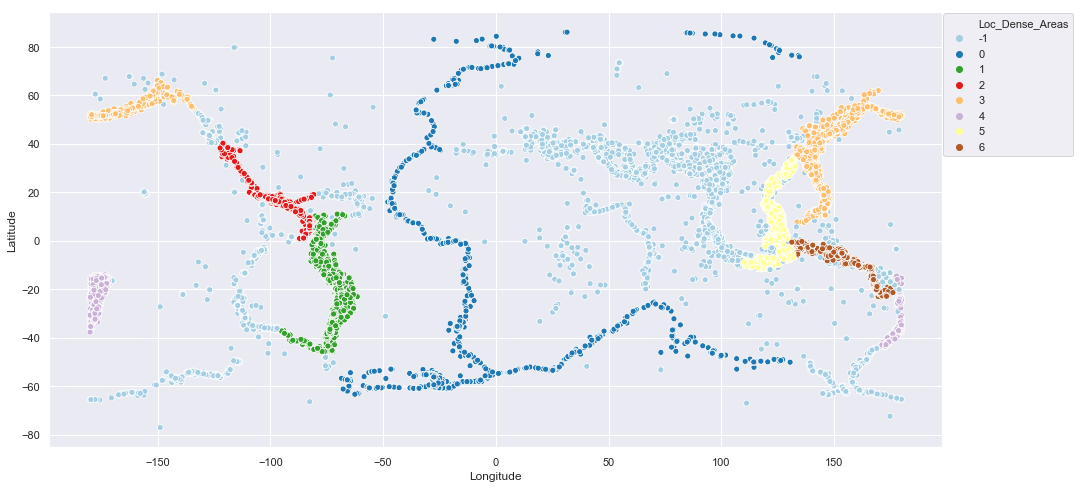

In [0]:
# plot of dense earthquake occurrence regions
seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2], palette='Paired',
                    hue='Loc_Dense_Areas', legend='full', data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

Finally, the 1080 cluster-size solution distinguished most of the neighboring data points for the 7 dense regions. These labels are: <br>
0: Mide-Atlantic Ridge and Antartic Plate; <br>
1: Peru–Chile Trench and the East of Nazca Plate; <br>
2: California San Andreas Fault and Middle America Trench; <br>
3: Aleutian Trench, Japan Trench extended to Mariana Trench; <br>
4: Tonga Trench and New Zealand; <br>
5: Phillipine Trench, Java Trench; <br>
6: Indonesian and Bougainville Trench. 

Generally, the so-called "Ring of Fire" could be depicted by these clusters.

To group the outlier points into a segement, we needed to choose a method for partion clustering, from the 32 clusters obtained with min_cluster_size=180, I specified k = 30. Comparing K-medoids and the spherical K-means on the intuitively 30-cluster solutions, the results were generally similar. Spherical K-means successfully distinguished the bending area along the Aleutian Trench in 1 cluster, while K-medoids sliced it into 5 clusters. K-medoids also messed up splitting the Indian-Arabian-African Plate boundary into 3 clusters, while spherical K-means recovered it nicely in 1 cluster. Results from spherical K-means was hence more preferred.

Diagnostics was not provided here, yet it would be encouraged to investigate average silhouette within clusters, gap statistic, or even by making more trials to choose the optimal number of clusters.

In [0]:
## fit a k-medoids clustering with pre-defined cluster size
from pyclustering.cluster.kmedoids import kmedoids
## 30 clusters
ini_med = np.array(range(1, 31))
kmed = kmedoids(flat, ini_med)
kmed.process()
projections1 = kmed.get_clusters()

## manually extract cluster labels for k-medoids
a = []
b = []
for x in range(0, len(projections1)):
    for y in range(0, len(projections1[x])):
        a.append(x)
        b.append(projections1[x][y])

kmed_member = pd.DataFrame(a, b)
predictions1 = kmed_member.sort_index(axis=0)

No handles with labels found to put in legend.


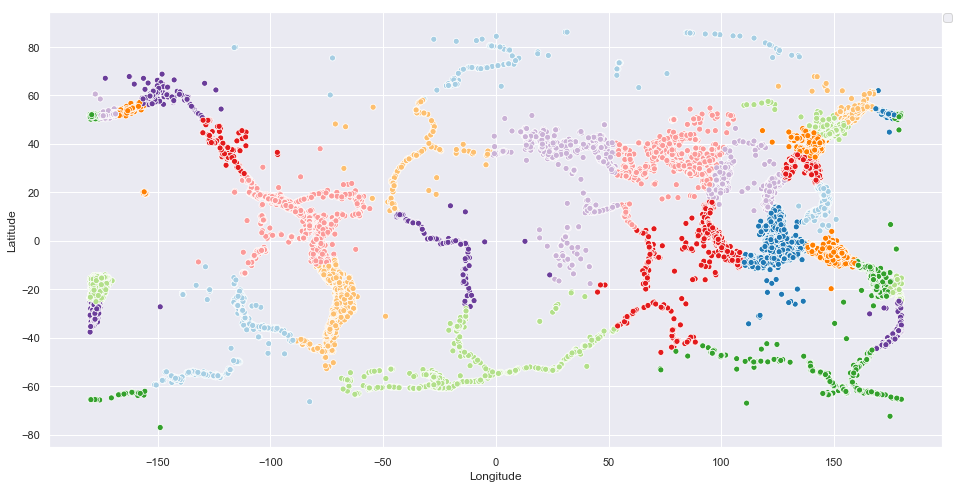

In [0]:
color_palette = seaborn.color_palette('deep', len(projections1))
kmed_cluster_colors = [color_palette[x] for x in predictions1[0]]

seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2], palette='Paired',
                    hue=kmed_cluster_colors, legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

In [0]:
## Use k-means from spherical clustering
from spherecluster import SphericalKMeans
spkmeans = SphericalKMeans(n_clusters=30, random_state=42)
spkmeans_labels = spkmeans.fit_predict(flat)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# append cluster membership column to the dataframe
df['Loc_partition'] = spkmeans_labels

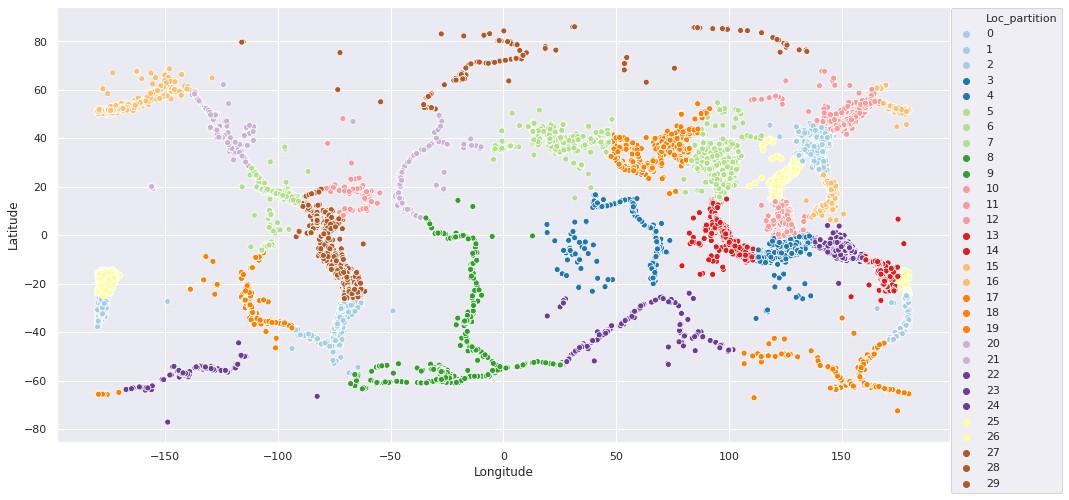

In [0]:
color_palette = seaborn.color_palette('deep', len(set(spkmeans_labels)))
spkm_cluster_colors = [color_palette[x] for x in spkmeans_labels]

seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2], palette='Paired',
                    hue='Loc_partition', legend='full', data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

#### Exploratory spline fitting and smoothing:

The dataset does not contain many features, besides time and spatial features, depth and magnitude are two critical information provided. Further exploring the relationship between depth and magnitude, smoothers like Lowess (non-parametric locally weighted regression for scatterplots) and robust regression are nice tools for investigating any observed pattern. The smoothing curves turned out to be rather flattened, merely concluding that magnitudes and depths of earthquakes did not have any relationship. 

Dividing the depths into four classes: 0 - 100 km; 100 - 300 km; 300 - 500 km; 500 - 700 km; the frequency plot of the four-class binned depths and boxplot of magnitude against depths further confirmed a rather imbalanced class as most earthquakes happened at a shallow underground layer within 100 km deep and falling into the scale between 5.5 to 6.0 in magnitude. We could try different binning ranges to split the classes, further breaking down < 100 km deep seems to be more representative.

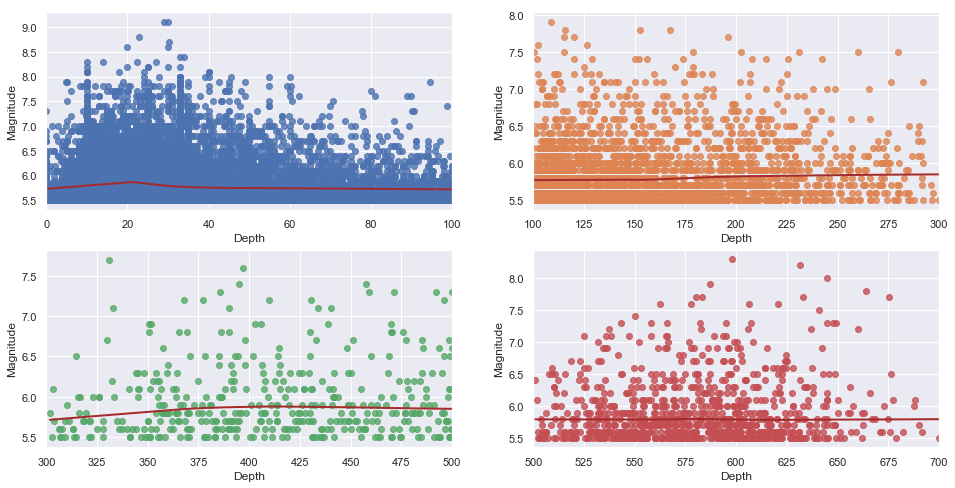

In [0]:
## Visualize depth, magnitude
# Scatter plot with splines using seaborn "lowess" or "robust" parameters
# LOWESS regression (locally weighted least square)

## plot by group of binned depths
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].set_xlim(0,100)
ax[0,1].set_xlim(100,300)
ax[1,0].set_xlim(300,500)
ax[1,1].set_xlim(500,700)
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='shallow'], 
                lowess=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='upper middle'], 
                lowess=True,ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,1])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='lower middle'], 
                lowess=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='deep'], 
                lowess=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,1])

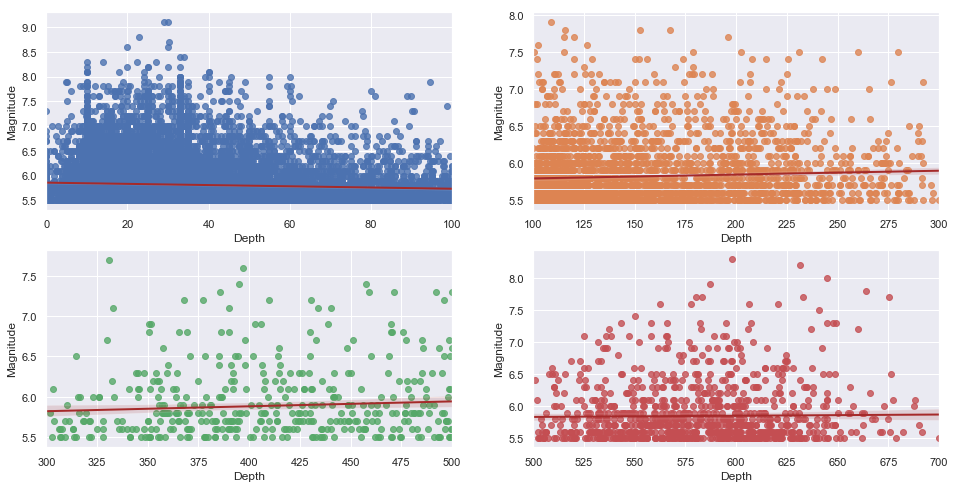

In [0]:
# robust regression with CI and 100 bootstrapping samples for CI estimation
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].set_xlim(0,100)
ax[0,1].set_xlim(100,300)
ax[1,0].set_xlim(300,500)
ax[1,1].set_xlim(500,700)
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='shallow'], 
                robust=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='upper middle'], 
                robust=True,ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,1])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='lower middle'], 
                robust=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='deep'], 
                robust=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,1])

In [0]:
# binning groups of magnitudes and depths
def bin_magnitude(x):
    if x < 6.0:
        y = '5.5 - 5.9'
    elif x < 7.0:
        y = '6.0 - 6.9'
    elif x < 8.0:
        y = '7.0 - 7.9'
    else:
        y = '8.0 or above'
    return y

def bin_depth(x):
    if x <= 100:
        y = 'shallow'
    elif x <= 300:
        y = 'upper middle'
    elif x <= 500:
        y = 'lower middle'
    else:
        y = 'deep'
    return y
    
df['bin_mag'] = [bin_magnitude(x) for x in df['Magnitude']]
df['bin_dep'] = [bin_depth(x) for x in df['Depth']]

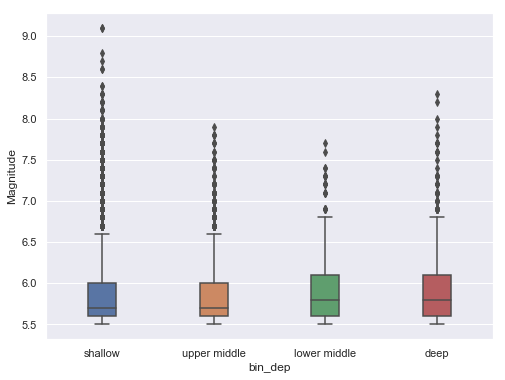

In [0]:
## dispersion of magnitude vs depths
seaborn.set(rc={'figure.figsize':(8.0, 6.0)})
seaborn.boxplot(x='bin_dep', y='Magnitude', data=df[['Magnitude', 'bin_dep']], 
                order=['shallow', 'upper middle', 'lower middle', 'deep'], width=0.25, whis=1.5)

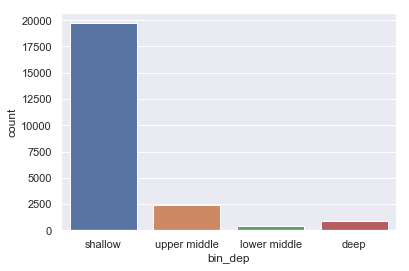

In [0]:
## number of earthquakes per binned depth
seaborn.set(rc={'figure.figsize':(6.0, 4.0)})
seaborn.countplot(x='bin_dep', data=df, order=['shallow', 'upper middle', 'lower middle', 'deep'])

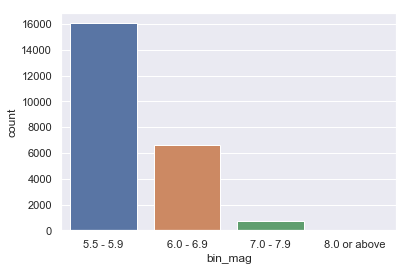

In [0]:
## number of earthquakes per binned magnitude
seaborn.countplot(x='bin_mag', data=df, order=['5.5 - 5.9', '6.0 - 6.9', '7.0 - 7.9', '8.0 or above'])

In [0]:
# further binning groups for shallow depths and more frequent low-magnitude earthquakes
# more balanced binning
def bin_depth_shallow(x):
    if x < 10: y = '< 10 km'
    elif x < 20: y = '10 - 20 km'
    elif x < 30: y = '20 - 30 km'
    elif x < 40: y = '30 - 40 km'
    elif x < 50: y = '40 - 50 km'
    elif x < 60: y = '50 - 60 km'
    elif x < 70: y = '60 - 70 km'
    elif x < 80: y = '70 - 80 km'
    elif x < 90: y = '80 - 90 km'
    elif x < 100: y = '90 - 100 km'
    else:
        y = '> 100 km'
    return y

def bin_magnitude_2(x):
    if x < 6.0: y = str(x)
    elif x < 7.0: y = '6.0 - 6.9'
    elif x < 8.0: y = '7.0 - 7.9'
    else: y = '8.0 or above'
    return y

df['bin_dep_shallow'] = [bin_depth_shallow(x) for x in df['Depth']]
df['bin_mag_2'] = [bin_magnitude_2(x) for x in df['Magnitude']]

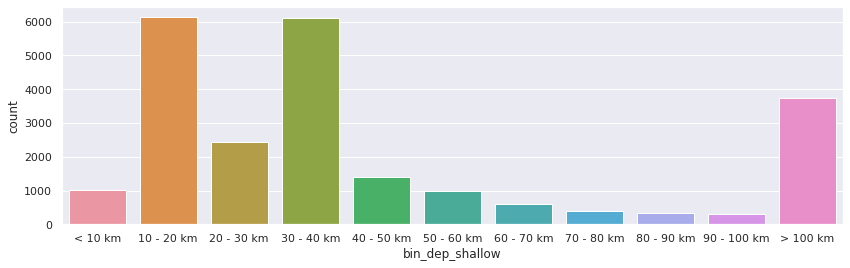

In [0]:
seaborn.set(rc={'figure.figsize':(14.0, 4.0)})
seaborn.countplot(x='bin_dep_shallow', data=df, order=['< 10 km', '10 - 20 km', '20 - 30 km', '30 - 40 km', 
                                                       '40 - 50 km', '50 - 60 km', '60 - 70 km', '70 - 80 km',
                                                       '80 - 90 km', '90 - 100 km', '> 100 km'])

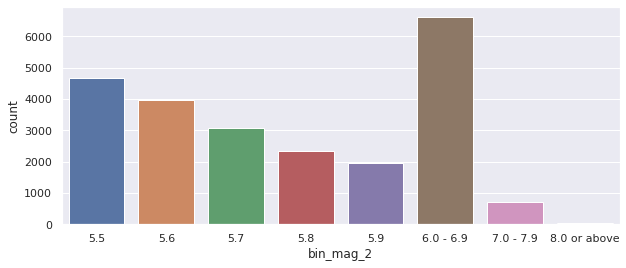

In [0]:
seaborn.set(rc={'figure.figsize':(10.0, 4.0)})
seaborn.countplot(x='bin_mag_2', data=df, order=['5.5', '5.6', '5.7', '5.8', '5.9', '6.0 - 6.9', '7.0 - 7.9', '8.0 or above'])

In [0]:
# cleaning improperly coded inputs
df['Date'][3378] = '1975-02-23'
df['Time'][3378] = '02:58:41'
df['Date'][7512] = '1985-04-28'
df['Time'][7512] = '02:53:41'
df['Date'][20650] = '2011-03-13'
df['Time'][20650] = '02:23:34'
# create a datetime column that allows numerical operations to apply for processing
df['period'] = df['Date'].map(str) + " " + df['Time'].map(str)
df['period'] = pd.to_datetime(df['period'], format='%Y-%m-%d %H:%M:%S')

In [0]:
## duplicate check; duplicates sourced from different semantic stations
print("Duplicated Timestamp found: " + str(df['period'][df['period'].duplicated()==True].count()))
## new dataset eliminating dulicates
df2 = df[df['period'].duplicated()==False]
df2 = df2.reset_index(drop=True)

Duplicated Timestamp found: 19


In [0]:
print(df2.shape)

(23393, 17)


In [0]:
df2.iloc[0:10,:]

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,year,month,day,Loc_Dense_Areas,Loc_partition,bin_mag,bin_dep,period,bin_dep_shallow,bin_mag_2
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,1965,1,2,3,16,6.0 - 6.9,upper middle,1965-01-02 13:44:18,> 100 km,6.0 - 6.9
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,1965,1,4,5,12,5.5 - 5.9,shallow,1965-01-04 11:29:49,80 - 90 km,5.8
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,1965,1,5,4,26,6.0 - 6.9,shallow,1965-01-05 18:05:58,20 - 30 km,6.0 - 6.9
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,1965,1,8,0,8,5.5 - 5.9,shallow,1965-01-08 18:49:43,10 - 20 km,5.8
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8,1965,1,9,5,12,5.5 - 5.9,shallow,1965-01-09 13:32:50,10 - 20 km,5.8
5,1965-01-10,13:36:32,-13.405,166.629,Earthquake,35.0,6.7,1965,1,10,6,14,6.0 - 6.9,shallow,1965-01-10 13:36:32,30 - 40 km,6.0 - 6.9
6,1965-01-12,13:32:25,27.357,87.867,Earthquake,20.0,5.9,1965,1,12,-1,7,5.5 - 5.9,shallow,1965-01-12 13:32:25,20 - 30 km,5.9
7,1965-01-15,23:17:42,-13.309,166.212,Earthquake,35.0,6.0,1965,1,15,6,14,6.0 - 6.9,shallow,1965-01-15 23:17:42,30 - 40 km,6.0 - 6.9
8,1965-01-16,11:32:37,-56.452,-27.043,Earthquake,95.0,6.0,1965,1,16,0,8,6.0 - 6.9,shallow,1965-01-16 11:32:37,90 - 100 km,6.0 - 6.9
9,1965-01-17,10:43:17,-24.563,178.487,Earthquake,565.0,5.8,1965,1,17,4,26,5.5 - 5.9,deep,1965-01-17 10:43:17,> 100 km,5.8


In [0]:
## redefine the binning groups with more balanced class distributions
def bin_depth_balance(x):
    if x < 10: y = '< 10 km'
    elif x < 20: y = '10 - 20 km'
    elif x < 30: y = '20 - 30 km'
    elif x < 40: y = '30 - 40 km'
    elif x < 50: y = '40 - 50 km'
    elif x < 100: y = '50 - 100 km'
    elif x < 300: y = '100 - 300 km'
    else:
        y = '> 300 km'
    return y

def bin_magnitude_balance(x):
    if x < 6.0: y = str(x)
    elif x < 6.5: y = '6.0 - 6.4'
    elif x < 7.0: y = '6.5 - 6.9'
    else: y = '7.0 or above'
    return y

df2['bin_dep'] = [bin_depth_balance(x) for x in df2['Depth']]
df2['bin_mag'] = [bin_magnitude_balance(x) for x in df2['Magnitude']]

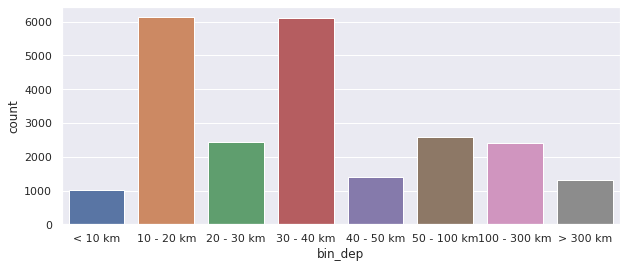

In [0]:
seaborn.set(rc={'figure.figsize':(10.0, 4.0)})
seaborn.countplot(x='bin_dep', data=df2, order=['< 10 km', '10 - 20 km', '20 - 30 km', '30 - 40 km', 
                                               '40 - 50 km', '50 - 100 km', '100 - 300 km', '> 300 km'])

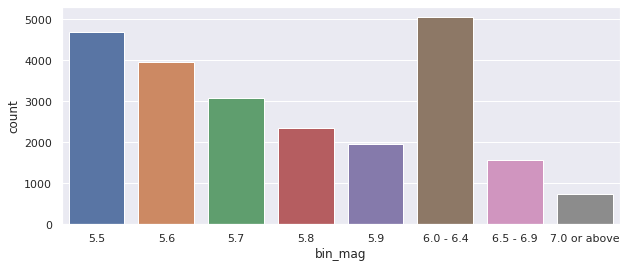

In [0]:
seaborn.set(rc={'figure.figsize':(10.0, 4.0)})
seaborn.countplot(x='bin_mag', data=df2, order=['5.5', '5.6', '5.7', '5.8', '5.9', '6.0 - 6.4', '6.5 - 6.9', '7.0 or above'])

In [0]:
df2['Loc_partition'] = df2['Loc_partition'].astype('category')
df2['Loc_Dense_Areas'] = df2['Loc_Dense_Areas'].astype('category')

#### Hidden Markov Model (HMM):

Hidden Markov Model has been widely used in analyzing sequential data, relying on the Markov property of a sequence of observations, as affected by the stochastic Markov process of another sequence(s) of latent unobservable variable(s). Based on what we could observe (the sequence of occurrence across the 30 spatially-clustered segments), the model treated every transition of discrete probability state at time t to be conditionally dependent on the transitional probability distribution of the previous state at time t - 1 only, as explained by the Markov memoryless property. 

Upon training the HMM with the time series data or given sequence of observations for the computations of parameters, the most likely state for the next timestep was determined by the Viterbi algorithm to maximize the probability among the paths to reach the next state, and the outcome of the next observation could be predicted by a state-to-outcome emission probability distribution, which could be gaussian or multinomial in common cases.

The following demonstrated a HMM with multinomial-distributed emission (clusters are discrete) trained using the sequence of earthquakes in these 30 K-means clusters from time 1 to time t - 10, and the HMM predicted the most likely segmented area that the next 5.5 or above magnitude earthquake would take place.

<img src="https://www.researchgate.net/profile/Jan_Bulla/publication/24115579/figure/fig1/AS:669552555864074@1536645177575/Basic-structure-of-a-Hidden-Markov-Model.png" width="500" />

Last 10 timesteps were reserved for testing purpose. The predictions of the fitted Hidden Markov Model was based on the last state returned and the related transition probability matrix computed from the convergence of probability of the state transitions in the obeserved sequence. Conceptually, due to this conditional independence of the historical paths, when the model predicted the state and emitted label for the next time step t + 1, the transition probability matrix and emission probability matrix needed to be updated. 

Due to stochasticity of HMM, we could sample the next state from all candidates in the Markov chain as weighted by the probability density, but not simply take the maximum probability, as HMM is a probabilistic generative model. The observed sequence possessed a large variance such that the diagonals of the converged transition matrix dominated the transitions. Trying to generate predictions repeatedly for a number of runs, we can get a probability distribution of the states to be appeared in the next 10 timesteps, and conclude a most probable prediction from the samples.

The model correctly predicted the label on time t + 1, i.e. the regional segment the next large earthquake would take place. For timesteps t + 2 to t + 10, we did a weighted sampling for 5 runs. Compared to the actual results, the model had given true alerts for the occurrence of earthquakes at the region segments labelled 0 and 4, yet also false alarms for region labels 14 and 26. Occurrences at labels 2, 6 and 21 were not detected by the model.

In [0]:
# Predicting the next possible earthquake regions, depths and magnitudes
# Hidden Markov Model (HMM)
from hmmlearn import hmm
np.random.seed(42)
from sklearn.utils import check_random_state
from numpy.random import choice

## Leave-p-out for testing
train_hmm = np.array(df2['Loc_partition'].head(len(df2) - 10))
test_hmm = np.array(df2['Loc_partition'].tail(len(df2) - len(train_hmm)))

## fit a multinomial HMM
model_hmm = hmm.MultinomialHMM(n_components=30, algorithm="viterbi", n_iter=300)
model_hmm.fit(train_hmm.reshape(-1, 1))

In [0]:
## generate predictions
def generate_samples_for_future(runs):

  next_state_pred = []
  next_label_pred = []

  for j in range(runs):

    next_state_pred_per_run = []
    next_label_pred_per_run = []

    for i in range(10):
      train_hmm = np.array(df2['Loc_partition'].head(len(df2) - 10))
      ## get the most likely hidden states for the training data
        ### current state = last predicted hidden state in training data
        ### at time t+1, predict next state from current state at time t
        ### sample a state among the transition probabilities for the next transition
      if i==0:
        state_region_hmm = model_hmm.predict(train_hmm.reshape(-1, 1))
        prob_next_state = model_hmm.transmat_[state_region_hmm[-1],:]
        state_next = prob_next_state.argmax()
      else:
        state_region_hmm = np.append(state_region_hmm, sample_state_next)
        state_next = sample_state_next

      ## get the emission probability distribution matrix for labels
        ### return label for this state
      label_next = model_hmm.emissionprob_[state_next,:].argmax()
      next_state_pred_per_run.append(state_next)
      next_label_pred_per_run.append(label_next)

      ## update the sequence
      train_hmm = np.append(train_hmm, label_next)

      ## sample a state among the probabilities for the next transition
      sample_state_next = choice(np.arange(0,30), 1, p=seq_region_infer.transmat_[state_region_hmm[-1],:])

    next_state_pred.append(next_state_pred_per_run)
    next_label_pred.append(next_label_pred_per_run)

  return next_state_pred, next_label_pred

next_state_pred, next_label_pred = generate_samples_for_future(runs=5)

In [0]:
# predict the regional cluster for the occurrence of earthquake at time t + 1
print("Predicted Label at time t + 1: ")
for a in range(5):
  print("Run " + str(a+1) + ": " + str(next_label_pred[a][0]))
print("Actual Label at time t + 1: " + str(test_hmm[0]))

Predicted Label at time t + 1: 
Run 1: 22
Run 2: 22
Run 3: 22
Run 4: 22
Run 5: 22
Actual Label at time t + 1: 22


In [0]:
# predict the regional cluster for the occurrence of earthquake at time t
print("Predicted Label at time t + 2 to t + 10: ")
for a in range(5):
  print("Run " + str(a+1) + ": " + str(next_label_pred[a][1:]))
print("Actual Label at time t + 2 to t + 10: " + str(test_hmm[1:].tolist()))

Predicted Label at time t + 2 to t + 10: 
Run 1: [22, 22, 22, 4, 25, 12, 12, 7, 26]
Run 2: [22, 22, 22, 22, 22, 22, 22, 0, 0]
Run 3: [13, 4, 14, 14, 14, 14, 16, 19, 12]
Run 4: [14, 14, 22, 22, 22, 13, 26, 12, 0]
Run 5: [26, 4, 4, 29, 29, 17, 26, 26, 14]
Actual Label at time t + 2 to t + 10: [2, 2, 6, 21, 21, 21, 0, 4, 0]


#### Conditional Random Field (CRF):

Conditional Random Field is another type of graphical model taking context and sequence of observed labels into account in the algorithm. Typically marked by the distinctive applications in the field of Natural Entity Recognition (NER) to generate linguistical and entity tagging of words in sentences; and image semantics context generation. Different from HMM which conditioned on the latest state, CRF assumes a globally conditional dependence between features of an observed and an output label sequence, and the two sequences are jointly distributed. Markov property of sequential dependency on previous observations, similar to HMM, is manifested in linear-chain CRF, and the inference is likewise made with Viterbi algorithm or maximum a posteriori approximations.

While HMM is generative to find the most likely sequence and hidden states, CRF is discriminative that the conditional probability inferred for the prediction of labels follows the form of a softmax function. CRF learns from the pre-defined features, which can be extracted from the sequence, and models the sequential dependence and relationships more characterized like a classifier. 

<img src="https://i.stack.imgur.com/khcnl.png" width="650" height="350"/>
<br><b>Reference from: </b>Sutton, Charles, and Andrew McCallum. <i>"An introduction to conditional random fields."</i> Foundations and Trends® in Machine Learning 4.4. (2012). p.267-373.


Py-crfsuite (or sklearn-crfsuite) is a package executed in Python environment for the fast CRF-suite application written in C++: <br> https://sklearn-crfsuite.readthedocs.io/en/latest/index.html. 

The CRF was fitted on features created from the depths and magnitudes in the past 200 lags, and the occurrence partitions of earthquake zones from t - 210 to t - 10, and used to predict the net 10 partition zones large-scale earthquakes would happen. Among the 10 testing timesteps, earthquakes actually occurred in only 6 zones. The predictions given by the fitte CRF model were also distributed in 6 zones, and among these 6 predicted zones of potential risk, 3 zones turned out to have earthquakes eventually happened. This suggested a comparable performance to the HMM fitted above, both getting 3 matching alerts out of 6 zones (segments 22, 4, 0 in common). One thing CRF might be better in some sense as it is discriminative, it did not require repeated stochastic sampling and generation of probabilistic predictions as in the inference procedure of HMM.

In [0]:
## create features of 200 time lagged events of the 3 features
shift_region_col, shift_depth_col, shift_magnitude_col = [], [], []
for lag in range(200):
  if lag < 1:
    shift_region = df2['Loc_partition'].shift(lag + 10)
    shift_depth = df2['Depth'].shift(lag + 10)
    shift_magnitude = df2['Magnitude'].shift(lag + 10)
  else:
    shift_region = pd.concat([shift_region, df2['Loc_partition'].shift(lag + 10)], axis=1)
    shift_depth = pd.concat([shift_depth, df2['Depth'].shift(lag + 11)], axis=1)
    shift_magnitude = pd.concat([shift_magnitude, df2['Magnitude'].shift(lag + 10)], axis=1)
  shift_region_col.append('Loc_partition_lag_' + str(lag + 10))
  shift_depth_col.append('Depth_lag_' + str(lag + 10))
  shift_magnitude_col.append('Magnitude_lag_' + str(lag + 10))

shift_region.columns, shift_depth.columns, shift_magnitude.columns = \
shift_region_col, shift_depth_col, shift_magnitude_col

In [0]:
## compile into dataframe and do train and test split
X_train = pd.concat([shift_region[210:-10], shift_depth[210:-10], shift_magnitude[210:-10]], axis=1)
y_train = pd.DataFrame(df2['Loc_partition'][210:-10])
X_test = pd.concat([shift_region[-10:], shift_depth[-10:], shift_magnitude[-10:]], axis=1)
y_test = pd.DataFrame(df2['Loc_partition'][-10:])

In [0]:
## convert into list of dictionaries of features and list of labels
X_train_dict = [[dict([i, str(x)] for i, x in d.items())] for d in X_train.to_dict('records')]
y_train_label = [[dict([i, str(x)] for i, x in d.items())['Loc_partition']] for d in y_train.to_dict('records')]
X_test_dict = [[dict([i, str(x)] for i, x in d.items())] for d in X_test.to_dict('records')]
y_test_label = [[dict([i, str(x)] for i, x in d.items())['Loc_partition']] for d in y_test.to_dict('records')]

In [0]:
import sklearn_crfsuite
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=300, all_possible_transitions=True)
crf.fit(X_train_dict, y_train_label)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=300,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [0]:
## prediction by fitted CRF
y_pred = crf.predict(X_test_dict)

In [0]:
print("Predicted Label at time t + 1 to t + 10: ")
print(y_pred)
print("Actual Label at time t + 1 to t + 10: ")
print(y_test_label)

Predicted Label at time t + 1 to t + 10: 
[['22'], ['14'], ['22'], ['4'], ['12'], ['12'], ['14'], ['4'], ['0'], ['26']]
Actual Label at time t + 1 to t + 10: 
[['22'], ['2'], ['2'], ['6'], ['21'], ['21'], ['21'], ['0'], ['4'], ['0']]


#### Bayesian Network:

For generalized directed graphical model, Bayesian network constructed the model architecture guided by a set of conditional probabilities determining the likelihood of occurrences of one class of the target vairable given all observed discrete classes or continuous values of its parent variables. Conditional dependences between two variables (expressed in nodes) were represented by a connecting edge. 

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/SimpleBayesNet.svg/800px-SimpleBayesNet.svg.png" width="600" /></center><br>
<i><center> Copy from Wikipedia "Bayesian Network" (https://en.wikipedia.org/wiki/Bayesian_network) </center></i> 

Typically, Bayes Net has limited power for large dimension problems as the time and space complexity of inference grows exponentially and the computation of probabilities becomes intractable. Continuous variables could be denoted as individual distributions with finite parameters like Gaussian mixtures, while the discret varaibles are more flexible to handle and easier for interpretations.

Engineers could define the arrangements of variables and dependences with prior beliefs by initialized probabilities of occurrences enumerating on every combination of discrete classes, or to set algorithms to learn the network structure by different heuristics. Common Bayesian inference methods include exact enumerations (with dynamic programming), using heuristics to determine variable ordering, e.g. greedy tree / A* search, variable elimination, and MCMC sampling. In "pomegranate" library, Chow–Liu tree is an especially fast algorithm for options.

To avoid exploding the learning time due to structural complexity given high dimensions, we contracted from 200 lags to only taking 10 lags of features and using the binarized features for depths and magnitudes.  Results of the Bayesian Network predicted cluster 22 and cluster 4 in the sequence of next 10 events successfully. It was similar to those predicted in HMM and CRF, also giving false alarms for cluster 14 and cluster 26.


In [0]:
### engineer features for the Bayes Net
### for depths and magnitudes, substitute continuous variables with the binned categorical variables, 
###   avoiding creating complexed node structures for training Bayes Net

shift_area_col, shift_region_col, shift_depth_bin_shallow_col, shift_magnitude_bin_col = [], [], [], []
for lag in range(10):
  if lag < 1:
    shift_area = df2['Loc_Dense_Areas'].shift(lag + 10)
    shift_region = df2['Loc_partition'].shift(lag + 10)
    shift_depth_bin_shallow = df2['bin_dep_shallow'].shift(lag + 10)
    shift_magnitude_bin = df2['bin_mag_2'].shift(lag + 10)
  else:
    shift_area =  pd.concat([shift_area, df2['Loc_Dense_Areas'].shift(lag + 10)], axis=1)
    shift_region = pd.concat([shift_region, df2['Loc_partition'].shift(lag + 10)], axis=1)
    shift_depth_bin_shallow = pd.concat([shift_depth_bin_shallow, df2['bin_dep_shallow'].shift(lag + 10)], axis=1)
    shift_magnitude_bin = pd.concat([shift_magnitude_bin, df2['bin_mag_2'].shift(lag + 10)], axis=1)

  shift_area_col.append('Area_lag_' + str(lag + 10))
  shift_region_col.append('Location_lag_' + str(lag + 10))
  shift_depth_bin_shallow_col.append('Depth_lag_' + str(lag + 10))
  shift_magnitude_bin_col.append('Magnitude_lag_' + str(lag + 10))

shift_area.columns, shift_region.columns, shift_depth_bin_shallow.columns, shift_magnitude_bin.columns = \
shift_area_col, shift_region_col, shift_depth_bin_shallow_col, shift_magnitude_bin_col

X_train = pd.concat([shift_area[20:-10], shift_region[20:-10], shift_depth_bin_shallow[20:-10], shift_magnitude_bin[20:-10]], axis=1)
y_train = pd.DataFrame(df2['Loc_partition'][20:-10])
X_test = pd.concat([shift_area[-10:], shift_region[-10:], shift_depth_bin_shallow[-10:], shift_magnitude_bin[-10:]], axis=1)
y_test = pd.DataFrame(df2['Loc_partition'][-10:])

In [0]:
from pomegranate import *
'''from documentation:
   "chow-liu" will return the optimal tree-like structure for the Bayesian network, which is a very fast approximation 
    but not always the best network;
   "greedy" that greedily attempts to find the best structure, and frequently can identify the optimal structure
   "exact"/"exact-dp" uses Dynamic Programming / A* to find the optimal Bayesian network'''

BN = BayesianNetwork.from_samples(pd.concat([X_train, y_train], axis=1), algorithm='chow-liu')

In [0]:
## prepare a data matrix with the label blanked out
test_sample = pd.concat([X_test.reset_index(drop=True), pd.DataFrame([None]*10)], axis=1)
test_sample.columns = [x for x in test_sample.columns[:-1]] + ['Loc_partition']

In [0]:
## gather predicted inference from the Bayes Net
pred_proba = []
for i in range(10):
  pred_proba.append(BN.predict_proba(test_sample.values.tolist()[i])[-1].items())

In [0]:
## get the predicted sequence
decode_label = []
for i in range(len(pred_proba)):
  for c in range(len(pred_proba[i])):
    if c==0:
      prob = pred_proba[i][c][1]
      class_ = pred_proba[i][c][0]
    else:
      if prob < pred_proba[i][c][1]:
        prob = pred_proba[i][c][1]
        class_ = pred_proba[i][c][0]
  decode_label.append(class_)

In [0]:
print("Predicted Event Sequence Label:")
print(decode_label)
print("Actual Event Sequence Label:")
print([y_test.values[z][0] for z in range(len(y_test))])

Predicted Event Sequence Label:
[22, 22, 22, 14, 26, 14, 22, 14, 4, 4]
Actual Event Sequence Label:
[22, 2, 2, 6, 21, 21, 21, 0, 4, 0]


#### Deep Belief Network (DBN) with stacked Restricted Boltzmann Machines (RBMs):

Restricted Boltzmann Machine is a type of network consisting visible observed nodes connected to multiple-hidden-layer nodes usually of lower dimensions. The network can learn to express in weightings of the asscoiations between the observed visible data and hidden units, which additional node of bias could also be fed in each hidden layer, making it shine on the applications of feature extraction, dimensionality reduction and autoencoder reconstruction. Increasing the number of hidden layers makes a deep Boltzmann Machine (DBM). Restricted and Unrestricted BMs are differentiated by whether connections exist between nodes within the same layer. Learnings are updated with gradient-based contrastive divergence algorithm commonly.

In sci-kit learn, only binary-valued (0 or 1) Bernoulli BM can be pipelined. Pydbm provides a better implementation for building deep BM. Deep Belief Network means using stacked RBM (or DBM) as top layers and use the extracted features from the BMs as inputs to a feed-forward neural network (or multiple-layer perceptron network) to complete the classification or regression tasks.

<img src="https://storage.googleapis.com/accel-brain-code/Deep-Learning-by-means-of-Design-Pattern/img/latex/image_dbn_and_dbm.png" width="640"/>
<br><i>quoted from pydbm documentation page, reference from: Salakhutdinov, R., Hinton, G. E. (2009). Deep boltzmann machines. In International conference on artificial intelligence and statistics (pp. 448-455). p451.</i>


Define 2 settings for analysis: <br>
<ul><li>The first contained all events in temporal sequence, and the target was to predict next earthquake's nature (depth, magnitude, time until next occurrence, geographical zone);<br></li>
<li>The second aggregated earthquakes in regular monthly intervals, and the target was to predict next month's aggregated data (average depth, maximum magnitude, average time until occurrence, count of occurrences, count of distinct zones involved and its ratio over total number of zones, etc.); <br></li></ul>

To engineer time series features, like in the graphical models, lagged values of features were taken, and we could trace the autocorrelation (ACF) and partial autocorrelation (PACF) plots over a large number of lags to determine the significance on how many to include. Augmented Dickey-Fuller test was used to test and confirm stationarity of the series of continuous features. It tests whether the time series could search a unit root, and if it could as the null hypothesis stated, it would be non-stationary. Rejection of the null guarantees stationarity.

In [0]:
## Set 1): All events of occrruences treated as individual time points; containing no aggregate.
## Set 2): Define monthly time intervals; containing aggregates on:
##          a. Depth (max, min, mean, range)
##          b. Magnitude (max, min, mean, range)
##          c. Time differences between events (inter- and intra- months)
##          d. Count of earthquakes
##          e. Same regional zones as previous earthquake or not

df2['Time_diff_prev'] = pd.Series([np.nan] + [(df2['period'].iloc[x] - df2['period'].iloc[x-1]).total_seconds() 
                                  for x in range(1, len(df2))])
df2['same_region_as_last'] = pd.Series([np.nan] + 
                                       [1 if df2['Loc_partition'].iloc[x] == df2['Loc_partition'].iloc[x-1] else 0 
                                        for x in range(1, len(df2))])
df2['same_area_as_last'] = pd.Series([np.nan] + 
                                     [1 if df2['Loc_Dense_Areas'].iloc[x] == df2['Loc_Dense_Areas'].iloc[x-1] else 0 
                                      for x in range(1, len(df2))])

df2 = df2[['year', 'month', 'day', 'period', 'Latitude', 'Longitude', 'Loc_Dense_Areas', 'Loc_partition', 
           'Depth',	'Magnitude', 'Time_diff_prev', 'same_region_as_last', 'same_area_as_last']]

In [0]:
df2

,year,month,day,period,Latitude,Longitude,Loc_Dense_Areas,Loc_partition,Depth,Magnitude,Time_diff_prev,same_region_as_last,same_area_as_last
0,1965,1,2,1965-01-02 13:44:18,19.2460,145.6160,3,16,131.60,6.0,NaN,NaN,NaN
1,1965,1,4,1965-01-04 11:29:49,1.8630,127.3520,5,12,80.00,5.8,164731.0,0.0,0.0
2,1965,1,5,1965-01-05 18:05:58,-20.5790,-173.9720,4,26,20.00,6.2,110169.0,0.0,0.0
3,1965,1,8,1965-01-08 18:49:43,-59.0760,-23.5570,0,8,15.00,5.8,261825.0,0.0,0.0
4,1965,1,9,1965-01-09 13:32:50,11.9380,126.4270,5,12,15.00,5.8,67387.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23388,2016,12,28,2016-12-28 08:22:12,38.3917,-118.8941,2,21,12.30,5.6,251.0,1.0,1.0
23389,2016,12,28,2016-12-28 09:13:47,38.3777,-118.8957,2,21,8.80,5.5,3095.0,1.0,1.0
23390,2016,12,28,2016-12-28 12:38:51,36.9179,140.4262,3,0,10.00,5.9,12304.0,0.0,0.0
23391,2016,12,29,2016-12-29 22:30:19,-9.0283,118.6639,5,4,79.00,6.3,121888.0,0.0,0.0


In [0]:
df3 = df2.groupby(['year', 'month']).agg({'Depth':['mean','min','max','std','median', 
                                                   lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)], 
                                          'Magnitude':['mean','min','max','std','median',
                                                       lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)], 
                                          'period':['count'],
                                          'Time_diff_prev':['mean','min','max','std','median',
                                                            lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
                                          'Loc_Dense_Areas':pd.Series.nunique,
                                          'same_area_as_last':['sum'],
                                          'Loc_partition':pd.Series.nunique,
                                          'same_region_as_last':['sum']})
df3 = df3.reset_index(level=['year', 'month'])
df3.columns = ['year', 'month', 'Average_depth', 'Min_depth', 'Max_depth', 'Std_depth', 'Median_depth', 'q1_depth', 'q3_depth',
               'Average_magnitude', 'Min_magnitude', 'Max_magnitude', 'Std_magnitude', 'Median_magnitude', 'q1_magnitude', 'q3_magnitude',
               'Count', 'Average_time_between_occurrences', 'Min_time_between_occurrences', 'Max_time_between_occurrences', 
               'Std_time_between_occurrences', 'Median_time_between_occurrences', 'q1_time_between_occurrences', 'q3_time_between_occurrences',
               'Distinct_Count_areas', 'Consec_areas_count', 'Distinct_Count_regions', 'Consec_regions_count']

df3['Range_depth'] = df3['Max_depth'] - df3['Min_depth']
df3['Range_magnitude'] = df3['Max_magnitude'] - df3['Min_magnitude']
df3['IQRange_depth'] = df3['q3_depth'] - df3['q1_depth']
df3['IQRange_magnitude'] = df3['q3_magnitude'] - df3['q1_magnitude']
df3['Involved_area_ratio'] = df3['Distinct_Count_areas'] / 8
df3['Involved_region_ratio'] = df3['Distinct_Count_regions'] / 30
df3['Consecutive_area_ratio'] = df3['Consec_areas_count'] / df3['Count']
df3['Consecutive_region_ratio'] = df3['Consec_regions_count'] / df3['Count']

df3 = df3.sort_values(by=['year', 'month'])

In [0]:
print(df3.shape)

(624, 36)


In [0]:
df3

,year,month,Average_depth,Min_depth,Max_depth,Std_depth,Median_depth,q1_depth,q3_depth,Average_magnitude,Min_magnitude,Max_magnitude,Std_magnitude,Median_magnitude,q1_magnitude,q3_magnitude,Count,Average_time_between_occurrences,Min_time_between_occurrences,Max_time_between_occurrences,Std_time_between_occurrences,Median_time_between_occurrences,q1_time_between_occurrences,q3_time_between_occurrences,Distinct_Count_areas,Consec_areas_count,Distinct_Count_regions,Consec_regions_count,Range_depth,Range_magnitude,IQRange_depth,IQRange_magnitude,Involved_area_ratio,Involved_region_ratio,Consecutive_area_ratio,Consecutive_region_ratio
0,1965,1,101.115385,15.000,565.00,152.237697,35.000,20.000,95.0000,6.123077,5.5,8.2,0.683318,5.90,5.8,6.000,13,193156.000000,36864.0,530016.0,164249.783576,137450.0,79426.75,269948.00,6,0.0,9,0.0,550.000,2.7,75.0000,0.200,0.750,0.300000,0.000000,0.000000
1,1965,2,47.712963,10.000,482.90,80.122216,25.100,20.075,34.3750,5.955556,5.6,8.7,0.510518,5.80,5.7,6.000,54,46278.796296,146.0,260997.0,69297.731631,11890.5,4344.25,48312.75,8,36.0,16,32.0,472.900,3.1,14.3000,0.300,1.000,0.533333,0.666667,0.592593
2,1965,3,62.055263,10.000,560.80,97.890288,31.300,25.000,47.8500,6.057895,5.5,7.6,0.536068,5.85,5.7,6.300,38,72949.105263,2106.0,312049.0,77728.408288,56743.5,16135.25,97170.50,8,3.0,15,2.0,550.800,2.1,22.8500,0.600,1.000,0.500000,0.078947,0.052632
3,1965,4,112.163636,10.000,635.00,183.812083,30.700,25.000,64.7000,5.945455,5.6,6.7,0.262311,6.00,5.7,6.100,33,76584.363636,1210.0,425609.0,86600.579073,47500.0,11686.00,112297.00,6,9.0,16,4.0,625.000,1.1,39.7000,0.400,0.750,0.533333,0.272727,0.121212
4,1965,5,80.972727,10.000,553.80,114.894839,35.000,25.875,105.0000,5.954545,5.5,7.7,0.467748,5.85,5.7,6.000,22,124990.318182,8871.0,689473.0,160370.317462,61841.5,32730.75,130878.25,8,2.0,13,2.0,543.800,2.2,79.1250,0.300,1.000,0.433333,0.090909,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2016,8,107.359143,3.250,533.00,180.056549,12.000,10.000,73.5000,5.945714,5.5,7.4,0.522631,5.80,5.6,6.100,35,76362.085714,62.0,564741.0,108332.589339,35858.0,16780.50,91967.50,7,11.0,17,7.0,529.750,1.9,63.5000,0.500,0.875,0.566667,0.314286,0.200000
620,2016,9,40.801674,5.557,596.40,92.849418,10.195,10.000,30.3925,5.805217,5.5,7.0,0.352273,5.70,5.5,6.000,46,52769.456522,48.0,235969.0,65533.879670,24665.5,4717.25,81422.25,8,14.0,20,9.0,590.843,1.5,20.3925,0.500,1.000,0.666667,0.304348,0.195652
621,2016,10,82.571111,5.630,614.00,159.688648,13.230,10.000,42.7875,5.827778,5.5,6.8,0.330896,5.80,5.6,5.900,36,76798.388889,3593.0,307666.0,68400.458453,58906.5,22117.75,120685.25,8,7.0,19,3.0,608.370,1.3,32.7875,0.300,1.000,0.633333,0.194444,0.083333
622,2016,11,72.086818,2.090,548.00,142.462439,14.905,10.000,44.7975,5.906818,5.5,7.8,0.475149,5.70,5.6,6.025,44,59102.795455,99.0,277844.0,69991.753022,28604.5,10590.75,85107.75,8,17.0,14,14.0,545.910,2.3,34.7975,0.425,1.000,0.466667,0.386364,0.318182


In [0]:
## filling if zero count / NaN exists in a particular month in the time series
def complete_count_zero(data):
    x = 0
    y = 1
    z = 1965
    comp = []
    for c in range(0, (2016-1965+1)*12):
        if data.iloc[x,1] != y:
            comp.append([z, y] + [np.NaN]*(data.shape[1]-2))
        else:
            x = x + 1
        y = y + 1
        if y > 12:
            y = 1
            z = z + 1
    if len(comp)>0:
      d_zero = pd.DataFrame(comp)
      d_zero.columns = data.columns
      df = pd.concat([data, d_zero], axis=0)
    else:
      df = data
    return df

df3 = complete_count_zero(df3)
df3 = df3.sort_values(by=['year', 'month'])
df3 = df3.reset_index(drop=True)

In [0]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(x):
    adtest = adfuller(x)
    test_stat = adtest[0]
    p_val = adtest[1]
    print('ADFuller Test Statistic for ' + x.name + ': %f' % test_stat)
    print('ADFuller Test P-value for ' + x.name + ': %f' % p_val)

stationarity_test(df2['Depth'])
stationarity_test(df2['Magnitude'])
stationarity_test(df2['Time_diff_prev'].iloc[1:])

ADFuller Test Statistic for Depth: -71.246554
ADFuller Test P-value for Depth: 0.000000
ADFuller Test Statistic for Magnitude: -16.726380
ADFuller Test P-value for Magnitude: 0.000000
ADFuller Test Statistic for Time_diff_prev: -14.867550
ADFuller Test P-value for Time_diff_prev: 0.000000


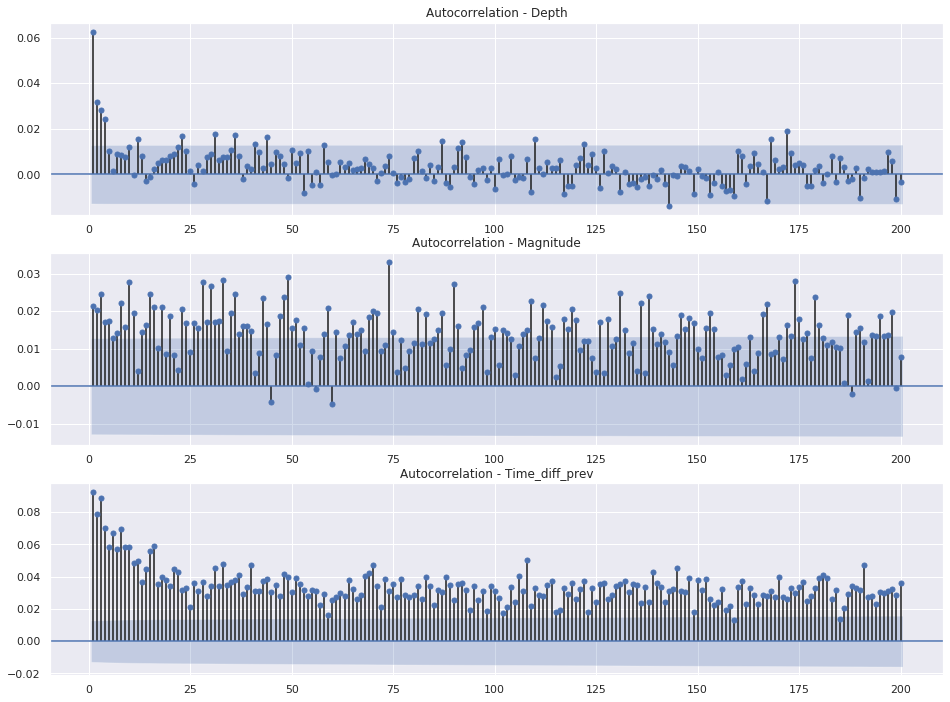

In [0]:
## diagnostics on lags of features for the Event-specific time series
from statsmodels.graphics.tsaplots import plot_acf
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,12))
p1 = plot_acf(df2['Depth'], lags=200, zero=False, ax=ax[0], title='Autocorrelation - Depth')
p2 = plot_acf(df2['Magnitude'], lags=200, zero=False, ax=ax[1], title='Autocorrelation - Magnitude')
p3 = plot_acf(df2['Time_diff_prev'].iloc[1:], lags=200, zero=False, ax=ax[2], title='Autocorrelation - Time_diff_prev')

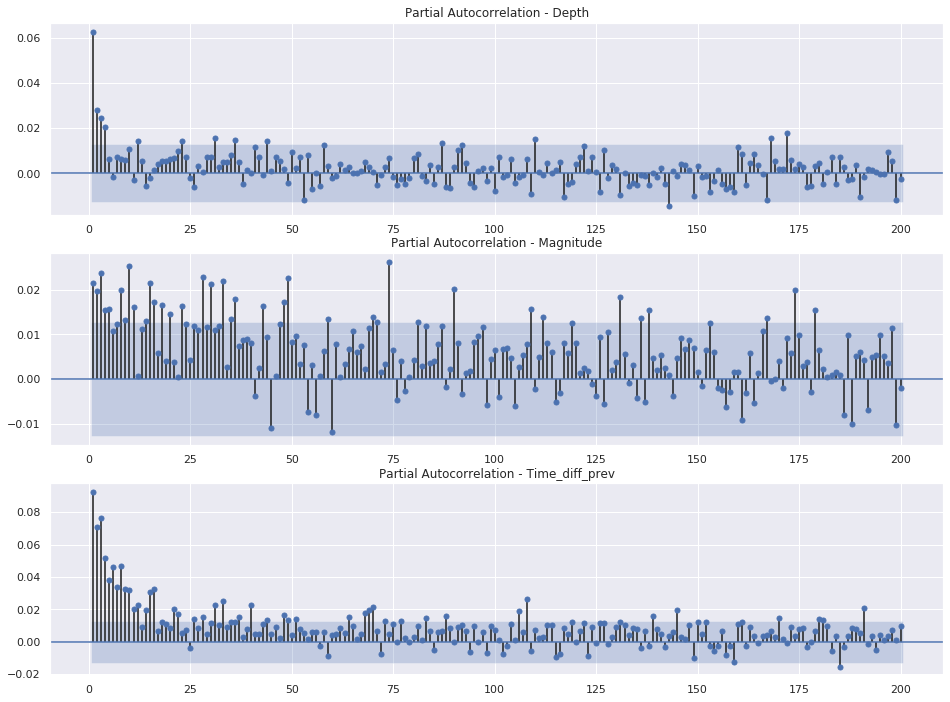

In [0]:
## diagnostics on lags of features for the Event-specific time series
from statsmodels.graphics.tsaplots import plot_pacf
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(16,12))
p1 = plot_pacf(df2['Depth'], lags=200, zero=False, ax=ax[0], title='Partial Autocorrelation - Depth')
p2 = plot_pacf(df2['Magnitude'], lags=200, zero=False, ax=ax[1], title='Partial Autocorrelation - Magnitude')
p3 = plot_pacf(df2['Time_diff_prev'].iloc[1:], lags=200, zero=False, ax=ax[2], title='Partial Autocorrelation - Time_diff_prev')

In [0]:
## Define function to extract lag features
def create_lagged_featue_set(df_features, num_features, num_lags, first_col_position):
  col = []
  for i in range(1, num_lags + 1):
    for j in range(first_col_position, num_features + first_col_position):
      df_features[df_features.columns[j] + '_lag%d' % i] = df_features[df_features.columns[j]].shift(i)
      col.append(df_features.columns[j] + '_lag%d' % i)

  feature_set = df_features[col]
  return feature_set

In [0]:
from sklearn.neural_network import BernoulliRBM, MLPRegressor, MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [0]:
## Take lags of 100 events for the "event-specific time series dataframe"
## Interested targets: "Depth", "Magnitude", "Time_difference_against_previous", "Location (8-cluster areas / 30-cluster regions)"

feature_set_df2 = create_lagged_featue_set(df2, 7, 100, 6)

X_train = feature_set_df2.iloc[101:-50,:]
minmax_scale_df2_x = MinMaxScaler().fit(X_train)
X_train_sc = minmax_scale_df2_x.transform(X_train)
X_test = feature_set_df2.iloc[-50:,:]
X_test_sc = minmax_scale_df2_x.transform(X_test)

minmax_scale_df2_y = MinMaxScaler().fit(df2.iloc[101:-50, 8:11])
y_train_sc = minmax_scale_df2_y.transform(df2.iloc[101:-50, 8:11])
y_test_sc = minmax_scale_df2_y.transform(df2.iloc[-50:, 8:11])

In [0]:
feature_set_df2

,Loc_Dense_Areas_lag1,Loc_partition_lag1,Depth_lag1,Magnitude_lag1,Time_diff_prev_lag1,same_region_as_last_lag1,same_area_as_last_lag1,Loc_Dense_Areas_lag2,Loc_partition_lag2,Depth_lag2,Magnitude_lag2,Time_diff_prev_lag2,same_region_as_last_lag2,same_area_as_last_lag2,Loc_Dense_Areas_lag3,Loc_partition_lag3,Depth_lag3,Magnitude_lag3,Time_diff_prev_lag3,same_region_as_last_lag3,same_area_as_last_lag3,Loc_Dense_Areas_lag4,Loc_partition_lag4,Depth_lag4,Magnitude_lag4,Time_diff_prev_lag4,same_region_as_last_lag4,same_area_as_last_lag4,Loc_Dense_Areas_lag5,Loc_partition_lag5,Depth_lag5,Magnitude_lag5,Time_diff_prev_lag5,same_region_as_last_lag5,same_area_as_last_lag5,Loc_Dense_Areas_lag6,Loc_partition_lag6,Depth_lag6,Magnitude_lag6,Time_diff_prev_lag6,...,Depth_lag95,Magnitude_lag95,Time_diff_prev_lag95,same_region_as_last_lag95,same_area_as_last_lag95,Loc_Dense_Areas_lag96,Loc_partition_lag96,Depth_lag96,Magnitude_lag96,Time_diff_prev_lag96,same_region_as_last_lag96,same_area_as_last_lag96,Loc_Dense_Areas_lag97,Loc_partition_lag97,Depth_lag97,Magnitude_lag97,Time_diff_prev_lag97,same_region_as_last_lag97,same_area_as_last_lag97,Loc_Dense_Areas_lag98,Loc_partition_lag98,Depth_lag98,Magnitude_lag98,Time_diff_prev_lag98,same_region_as_last_lag98,same_area_as_last_lag98,Loc_Dense_Areas_lag99,Loc_partition_lag99,Depth_lag99,Magnitude_lag99,Time_diff_prev_lag99,same_region_as_last_lag99,same_area_as_last_lag99,Loc_Dense_Areas_lag100,Loc_partition_lag100,Depth_lag100,Magnitude_lag100,Time_diff_prev_lag100,same_region_as_last_lag100,same_area_as_last_lag100
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,16,131.6,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,12,80.0,5.8,164731.0,0.0,0.0,3,16,131.6,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,26,20.0,6.2,110169.0,0.0,0.0,5,12,80.0,5.8,164731.0,0.0,0.0,3,16,131.60,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,15.0,5.8,261825.0,0.0,0.0,4,26,20.0,6.2,110169.0,0.0,0.0,5,12,80.00,5.8,164731.0,0.0,0.0,3,16,131.60,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23388,2,21,10.8,5.6,32225.0,0.0,0.0,-1,6,97.0,5.6,204523.0,0.0,0.0,1,2,14.93,5.6,586.0,1.0,1.0,1,2,38.00,7.6,123812.0,0.0,0.0,6,22,30.00,5.8,8799.0,1.0,1.0,6,22,35.00,6.0,204499.0,...,457.86,5.8,52554.0,0.0,0.0,6,22,45.15,5.9,32040.0,0.0,0.0,1,2,12.57,6.0,31179.0,0.0,0.0,3,15,13.89,5.9,12927.0,0.0,0.0,5,12,61.00,5.8,26078.0,0.0,0.0,0,9,10.00,5.6,20704.0,0.0,0.0
23389,2,21,12.3,5.6,251.0,1.0,1.0,2,21,10.8,5.6,32225.0,0.0,0.0,-1,6,97.00,5.6,204523.0,0.

In [0]:
## create stacked RBM based on sklearn wrapped API
def DBN_fit(y_train_cont, y_train_discret, X_train_sc):
  y_train_cont = y_train_cont
  y_train_discret = y_train_discret
  y_train_sc = MinMaxScaler().fit_transform(y_train_cont)

  rbm1 = BernoulliRBM(n_components=2500, learning_rate=0.1, n_iter=100, batch_size=128, verbose=1, random_state=42)
  rbm2 = BernoulliRBM(n_components=1000, learning_rate=0.1, n_iter=100, batch_size=128, verbose=1, random_state=42)
  rbm3 = BernoulliRBM(n_components=250, learning_rate=0.1, n_iter=100, batch_size=128, verbose=1, random_state=42)

  dbm = Pipeline(steps=[('RBM_layer_1', rbm1), ('RBM_layer_2', rbm2), ('RBM_layer_3', rbm3)])
  dbm.fit(X_train_sc)

  dbnr = MLPRegressor(hidden_layer_sizes=(250, 100, 50, 25, 10, ), activation='relu', learning_rate_init=0.00001, 
                      solver='adam', batch_size=16, alpha=0.0001, max_iter=5000, shuffle=False, random_state=42)
  dbnr.fit(X_train_rbm, y_train_sc)

  dbnc = []
  for c in range(y_train_discret.shape[1]):
    dbnc_ = MLPClassifier(hidden_layer_sizes=(250, 100, 50, 25, ), activation='relu', learning_rate_init=0.001, 
                          solver='adam', alpha=0.0001, max_iter=500, shuffle=False, random_state=42)
    dbnc_.fit(X_train_rbm, y_train_discret.iloc[:,c])
    dbnc.append(dbnc_)

  return dbm, dbnr, dbnc

DBM, DBN_cont, DBN_discret = DBN_fit(df2.iloc[101:-50, 8:11], df2.iloc[101:-50, 6:8], X_train_sc)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -352.91, time = 25.03s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -322.12, time = 34.68s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -302.80, time = 34.79s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -301.58, time = 35.12s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -299.07, time = 35.41s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -295.64, time = 35.16s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -289.15, time = 35.24s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -286.81, time = 34.93s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -283.80, time = 35.19s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -281.31, time = 34.89s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -279.70, time = 34.52s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -281.52, time = 34.50s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -277.78, time = 34.41s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -275.88, time = 34.46s
[

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
from joblib import dump, load
dump(DBM, F"/content/drive/My Drive/DBM.joblib")
DBM = load(F'/content/drive/My Drive/DBM.joblib')

In [0]:
# infer transformed array from trained DBM
X_train_rbm = DBM.transform(X_train_sc)

In [0]:
# for classification of location features (8-cluster & 30-cluster)
DBN_discret = []
for c in range(df2.iloc[101:-50, 6:8].shape[1]):
  dbnc_ = MLPClassifier(hidden_layer_sizes=(250, 100, 50, 25, ), activation='relu', learning_rate_init=0.001, 
                        solver='adam', alpha=0.0001, max_iter=500, shuffle=False, random_state=42)
  dbnc_.fit(X_train_rbm, df2.iloc[101:-50, 6:8].iloc[:,c])
  DBN_discret.append(dbnc_)

In [0]:
# for regression of depth, magnitude and time until next occurrence
DBN_cont = MLPRegressor(hidden_layer_sizes=(250, 100, 50, 25, 10, ), activation='relu', learning_rate_init=0.00001, 
                        solver='adam', batch_size=16, alpha=0.0001, max_iter=5000, shuffle=False, random_state=42)
DBN_cont.fit(X_train_rbm, y_train_sc)
DBN_cont.out_activation_ = "tanh"     ## define the activation function for the output layer

In [0]:
## make predictions for latest 50 events
pred_cont = []
pred_discret = []
lag_pred = []

for next_steps in range(50):
  if next_steps == 0:
    rbm_extracted = DBM.transform(X_test_sc[0,:].reshape(1,-1))
    pred_arr = rbm_extracted
    pred_values = DBN_cont.predict(pred_arr)
    pred_areas = DBN_discret[0].predict(pred_arr)
    pred_regions = DBN_discret[1].predict(pred_arr)

    pred_cont.append(pred_values)
    pred_discret.append(pred_areas + pred_regions)

    for length in range(len(pred_values[0])):
      lag_pred.append(pred_values[0][length])

    var_same_areas = 1 if X_test_sc[0,500]==pred_areas[0] else 0
    var_same_regions = 1 if X_test_sc[0,600]==pred_regions[0] else 0
    lag_pred.append(var_same_areas)
    lag_pred.append(var_same_regions)
    
  else:
    pred_arr_ = np.array(lag_pred + X_test_sc[next_steps, (next_steps*7):].tolist()).reshape(1,-1)

    rbm_extracted = DBM.transform(pred_arr_)
    pred_arr = rbm_extracted
    pred_values = DBN_cont.predict(pred_arr)
    pred_areas = DBN_discret[0].predict(pred_arr)
    pred_regions = DBN_discret[1].predict(pred_arr)

    pred_cont.append(pred_values)
    pred_discret.append(pred_areas + pred_regions)

    for length in range(len(pred_values[0])):
      lag_pred.append(pred_values[0][length])

    var_same_areas = 1 if var_same_areas==pred_areas[0] else 0
    var_same_regions = 1 if var_same_regions==pred_regions[0] else 0
    lag_pred.append(var_same_areas)
    lag_pred.append(var_same_regions)

In [0]:
## convert to ndarray
pred_cont = np.array([pred_cont[x].flatten() for x in range(len(pred_cont))])
## invert to original scale
inv_pred_cont = minmax_scale2.inverse_transform(pred_cont)

<b>For event-based dataset:</b>

Predictive performances were tested through stacking 3 layers of scikit-learn Bernoulli RBM with a deep MLP classifier for location attributes and MLP regressor for continuous attributes, forming a DBN model. On the 8 clusters of intensive occurrence areas, the first 20 events predicted got a 55% accuracy, while for the later 30 forecasts, the predictive power degraded as the models converged to predicting the same zone. On the more complex 30 clusters of partitioned regions, consecutive earthquakes at cluster 14 occurred earlier between the future 8-th and 18-th events, while predictions by the model gave the consecutive patterns of cluster 14 after the 25-th event. Overall, it still had over 22% accuracy for the next 40 forecasts.

Similarly, the model inflated its forecasts for the 3 continuous attributes of depth, magnitude and time until next event starting from around the 25-th event. It was restricted only to short-term forecasts, being poor in recursive predictions of long-term events. Feature extractions by Bernoulli DBM might be a choice for binary-class or multinomial-class targets, yet for continuous targets we might have to seek for a gaussian distributed DBM. Owing to this reason, for monthly dataset, the pydbm module would fulfil the job.

<b>For monthly-spaced dataset:</b>

Pedictions for the next 20 months on the 9 selected more critical features were examined. "Count of earthquakes" and "Average time difference between current and next earthquake" got comparatively referenceable results with mean absolute percentage error (scaling considered) between 3% to 6%. On "Average depth" and "Maximum magnitude", the model learnt to smooth the predicted curves on narrower ranges around the mean in a sense to minimize overall errors. Earthquake data were noisy containing particularly rare extremes, this accounted for the major challenge to model the uncertainty in the context of making purely statistical forecast without simulations on physical systems. To avoid noises, we could consider fourier transform, and modelling on the denoised trends of the time series.


In [0]:
from sklearn.metrics import accuracy_score

In [0]:
print("Predicted next 50 occurrences: ")
print(lag_pred_area)
print("Actual next 50 occurrences: ")
print(df2.iloc[-50:, 6].values.tolist())

Predicted next 50 occurrences: 
[-1, 5, 3, 6, -1, -1, 6, 6, 6, 6, 6, 6, 6, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Actual next 50 occurrences: 
[4, 5, 5, -1, -1, -1, -1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, -1, 6, 3, 3, 2, 6, 6, 6, 6, -1, 6, 3, 6, 1, 6, -1, 6, 6, 5, 3, 6, 6, 1, 1, -1, 2, 2, 2, 3, 5, 3]


In [0]:
print("Accuracy for all next 50 occurrences: ")
print(accuracy_score(df2.iloc[-50:, 6].values.tolist(), lag_pred_area))
print("Accuracy for all next 20 occurrences: ")
accuracy_score(df2.iloc[-50:, 6].values.tolist()[:20], lag_pred_area[:20])

Accuracy for all next 50 occurrences: 
0.28
Accuracy for all next 20 occurrences: 


0.55

In [0]:
print("Predicted next 50 occurrences: ")
print(lag_pred_region)
print("Actual next 50 occurrences: ")
print(df2.iloc[-50:, 7].values.tolist())

Predicted next 50 occurrences: 
[13, 29, 12, 14, 15, 13, 4, 13, 13, 22, 15, 4, 26, 14, 26, 26, 26, 22, 22, 22, 22, 22, 22, 22, 22, 14, 14, 14, 14, 22, 22, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
Actual next 50 occurrences: 
[26, 12, 4, 11, 13, 19, 21, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 22, 18, 14, 16, 16, 5, 22, 22, 22, 14, 18, 22, 16, 14, 28, 14, 7, 14, 14, 4, 16, 22, 22, 2, 2, 6, 21, 21, 21, 0, 4, 0]


In [0]:
print("Accuracy for all next 50 occurrences: ")
print(accuracy_score(df2.iloc[-50:, 7].values.tolist(), lag_pred_region))
print("Accuracy for all next 40 occurrences: ")
print(accuracy_score(df2.iloc[-50:, 7].values.tolist()[:40], lag_pred_region[:40]))

Accuracy for all next 50 occurrences: 
0.18
Accuracy for all next 40 occurrences: 
0.225


In [0]:
## Actual vs Predict plot generation
def plot_actual_pred(z, y, time_range, ax):
  z = pd.DataFrame(z, columns=['value'])
  y = pd.DataFrame(y, columns=['value'])
  z['class'] = 'Predicted'
  y['class'] = 'Actual'
  z['time'] = pd.Series(np.array(range(1, time_range + 1)))
  y['time'] = pd.Series(np.array(range(1, time_range + 1)))
  zy = pd.concat([z, y])
  seaborn.lineplot(x='time', y='value', hue='class', data=zy, ax=ax)
  return

Depth:


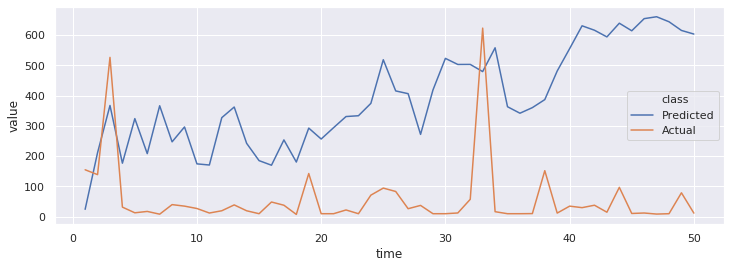

In [0]:
# hidden_layer_sizes=(250, 200, 150, 100, 50, 25, ), activation='relu', learning_rate_init=0.0001, solver='adam', batch_size=8, alpha=0.0001, max_iter=1000
fig, ax = plt.subplots(nrows=1, ncols=1)
seaborn.set(rc={'figure.figsize':(12.0, 4.0)})
print("Depth:")
plot_actual_pred(inv_pred_cont[:,0], np.array(df2.iloc[-50:,8]), 50, ax)

Magnitude:


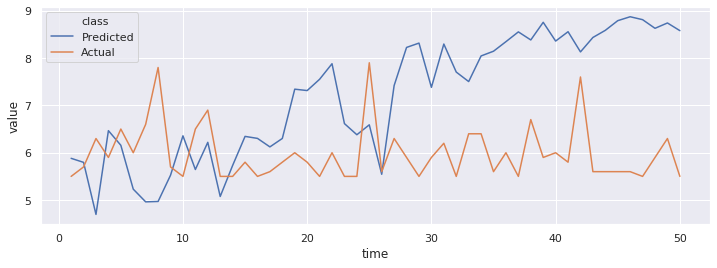

In [0]:
# hidden_layer_sizes=(250, 100, 50, 25, ), activation='relu', learning_rate_init=0.00001, solver='adam', batch_size=24, alpha=0.0001, max_iter=5000
fig, ax = plt.subplots(nrows=1, ncols=1)
seaborn.set(rc={'figure.figsize':(12.0, 4.0)})
print("Magnitude:")
plot_actual_pred(inv_pred_cont[:,1], np.array(df2.iloc[-50:,9]), 50, ax)

Time_diff_prev:


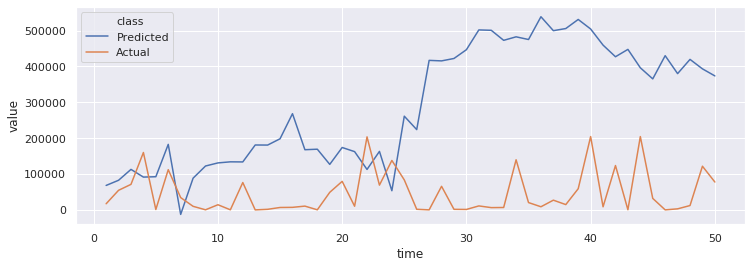

In [0]:
# hidden_layer_sizes=(250, 100, 50, 25, 10, ), activation='relu', learning_rate_init=0.00001, solver='adam', batch_size=16, alpha=0.0001, max_iter=5000
fig, ax = plt.subplots(nrows=1, ncols=1)
seaborn.set(rc={'figure.figsize':(12.0, 4.0)})
print("Time_diff_prev:")
plot_actual_pred(inv_pred_cont[:,2], np.array(df2.iloc[-50:,10]), 50, ax)

In [0]:
## Take lags of 24 months for the "monthly-specific time series dataframe"
## Interested targets: "Average_Depth", "Max_Magnitude", "Average_Time_difference_against_previous", "Count", "Involved"

feature_set_df3 = create_lagged_featue_set(df3, 34, 24, 2)

X_train = feature_set_df3.iloc[24:-20,:]
minmax_scale_df3_x = MinMaxScaler().fit(X_train)
X_train_sc = minmax_scale_df3_x.transform(X_train)
X_test = feature_set_df3.iloc[-20:,:]
X_test_sc = minmax_scale_df3_x.transform(X_test)

minmax_scale_df3_y = MinMaxScaler().fit(df3.iloc[24:-20, 2:36])
y_train_sc = minmax_scale_df3_y.transform(df3.iloc[24:-20, 2:36])
y_test_sc = minmax_scale_df3_y.transform(df3.iloc[-20:, 2:36])

In [0]:
feature_set_df3

,Average_depth_lag1,Min_depth_lag1,Max_depth_lag1,Std_depth_lag1,Median_depth_lag1,q1_depth_lag1,q3_depth_lag1,Average_magnitude_lag1,Min_magnitude_lag1,Max_magnitude_lag1,Std_magnitude_lag1,Median_magnitude_lag1,q1_magnitude_lag1,q3_magnitude_lag1,Count_lag1,Average_time_between_occurrences_lag1,Min_time_between_occurrences_lag1,Max_time_between_occurrences_lag1,Std_time_between_occurrences_lag1,Median_time_between_occurrences_lag1,q1_time_between_occurrences_lag1,q3_time_between_occurrences_lag1,Distinct_Count_areas_lag1,Consec_areas_count_lag1,Distinct_Count_regions_lag1,Consec_regions_count_lag1,Range_depth_lag1,Range_magnitude_lag1,IQRange_depth_lag1,IQRange_magnitude_lag1,Involved_area_ratio_lag1,Involved_region_ratio_lag1,Consecutive_area_ratio_lag1,Consecutive_region_ratio_lag1,Average_depth_lag2,Min_depth_lag2,Max_depth_lag2,Std_depth_lag2,Median_depth_lag2,q1_depth_lag2,...,IQRange_depth_lag23,IQRange_magnitude_lag23,Involved_area_ratio_lag23,Involved_region_ratio_lag23,Consecutive_area_ratio_lag23,Consecutive_region_ratio_lag23,Average_depth_lag24,Min_depth_lag24,Max_depth_lag24,Std_depth_lag24,Median_depth_lag24,q1_depth_lag24,q3_depth_lag24,Average_magnitude_lag24,Min_magnitude_lag24,Max_magnitude_lag24,Std_magnitude_lag24,Median_magnitude_lag24,q1_magnitude_lag24,q3_magnitude_lag24,Count_lag24,Average_time_between_occurrences_lag24,Min_time_between_occurrences_lag24,Max_time_between_occurrences_lag24,Std_time_between_occurrences_lag24,Median_time_between_occurrences_lag24,q1_time_between_occurrences_lag24,q3_time_between_occurrences_lag24,Distinct_Count_areas_lag24,Consec_areas_count_lag24,Distinct_Count_regions_lag24,Consec_regions_count_lag24,Range_depth_lag24,Range_magnitude_lag24,IQRange_depth_lag24,IQRange_magnitude_lag24,Involved_area_ratio_lag24,Involved_region_ratio_lag24,Consecutive_area_ratio_lag24,Consecutive_region_ratio_lag24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101.115385,15.000,565.0,152.237697,35.000,20.000,95.0000,6.123077,5.5,8.2,0.683318,5.90,5.8,6.000,13.0,193156.000000,36864.0,530016.0,164249.783576,137450.0,79426.75,269948.00,6.0,0.0,9.0,0.0,550.000,2.7,75.0000,0.200,0.750,0.300000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.712963,10.000,482.9,80.122216,25.100,20.075,34.3750,5.955556,5.6,8.7,0.510518,5.80,5.7,6.000,54.0,46278.796296,146.0,260997.0,69297.731631,11890.5,4344.25,48312.75,8.0,36.0,16.0,32.0,472.900,3.1,14.3000,0.300,1.000,0.533333,0.666667,0.592593,101.115385,15.000,565.00,152.237697,35.000,20.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62.055263,10.000,560.8,97.890288,31.300,25.000,47.8500,6.057895,5.5,7.6,0.536068,5.85,5.7,6.300,38.0,72949.105263,2106.0,312049.0,77728.408288,56743.5,16135.25,97170.50,8.0,3.0,15.0,2.0,550.800,2.1,22.8500,0.600,1.000,0.500000,0.078947,0.052632,47.712963,10.000,482.90,80.122216,25.100,20.075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112.163636,10.000,635.0,183.812083,30.700,25.000,64.7000,5.945455,5.6,6.7,0.262311,6.00,5.7,6.100,33.0,76584.363636,1210.0,425609.0,86600.579073,47500.0,11686.00,112297.00,6.0,9.0,16.0,4.0,625.000,1.1,39.7000,0.400,0.750,0.533333,0.272727,0.121212,62.055263,10.000,560.80,97.890288,31.300,25.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [0]:
from pydbm.dbm.deep_boltzmann_machine import DeepBoltzmannMachine
from pydbm.dbm.deepboltzmannmachine.stacked_auto_encoder import StackedAutoEncoder
from pydbm.dbm.builders.dbm_multi_layer_builder import DBMMultiLayerBuilder
from pydbm.approximation.contrastive_divergence import ContrastiveDivergence
from pydbm.activation.logistic_function import LogisticFunction
from pydbm.activation.tanh_function import TanhFunction
from pydbm.activation.relu_function import ReLuFunction
from pydbm.optimization.optparams.adam import Adam
from pydbm.optimization.optparams.sgd import SGD

In [0]:
dbm = DeepBoltzmannMachine(
    DBMMultiLayerBuilder(),
    # Dimension in visible layer, hidden layer, and second hidden layer.
    [X_train_sc.shape[1], X_train_sc.shape[1]/4, X_train_sc.shape[1]],
    # Activations in visible layer, hidden layer, and second hidden layer.
    [TanhFunction(), TanhFunction(), TanhFunction()],
    [ContrastiveDivergence(opt_params=SGD(momentum=0.9)), ContrastiveDivergence(opt_params=SGD(momentum=0.9))],
    learning_rate=0.01)
# Execute learning
dbm.learn(X_train_sc, training_count=1000, batch_size=X_train_sc.shape[0], r_batch_size=10)

In [0]:
dbm.save_pre_learned_params(
    dir_path=F"/content/drive/My Drive/", file_name="DBM3")

In [0]:
dbm = DeepBoltzmannMachine(
    DBMMultiLayerBuilder(
        pre_learned_path_list=[
           F"/content/drive/My Drive/DBM3_0.npz",
           F"/content/drive/My Drive/DBM3_1.npz"]),
    [X_train_sc.shape[1], X_train_sc.shape[1]/4, X_train_sc.shape[1]],
    # Activations in visible layer, hidden layer, and second hidden layer.
    [TanhFunction(), TanhFunction(), TanhFunction()],
    [ContrastiveDivergence(opt_params=SGD(momentum=0.9)), ContrastiveDivergence(opt_params=SGD(momentum=0.9))],
    learning_rate=0.01)

In [0]:
X_train_rbm = np.matmul(np.matmul(X_train_sc, dbm.get_weight_arr_list()[0]), 
                        dbm.get_weight_arr_list()[1])
X_test_rbm = np.matmul(np.matmul(X_test_sc, dbm.get_weight_arr_list()[0]), 
                       dbm.get_weight_arr_list()[1])
scale_rbm = StandardScaler().fit(X_train_rbm)
X_train_rbm_sc = scale_rbm.transform(X_train_rbm)
X_test_rbm_sc = scale_rbm.transform(X_test_rbm)

In [0]:
DBN_month = MLPRegressor(hidden_layer_sizes=(800, 100, ), activation='relu', learning_rate_init=0.00001, 
                        solver='adam', batch_size=2, alpha=0.0001, max_iter=5000, shuffle=False, random_state=42)
DBN_month.fit(X_train_rbm_sc, y_train_sc)
DBN_month.out_activation_ = "identity"

In [0]:
pred_cont = []
lag_pred = []

for next_steps in range(20):
  if next_steps == 0:
    rbm_extracted = np.matmul(np.matmul(X_test_sc[0,:].reshape(1,-1), 
                                        dbm.get_weight_arr_list()[0]), 
                              dbm.get_weight_arr_list()[1])
    pred_arr =  scale_rbm.transform(rbm_extracted)
    pred_values = DBN_month.predict(pred_arr)

    pred_cont.append(pred_values)

    for length in range(len(pred_values[0])):
      lag_pred.append(pred_values[0][length])

  else:
    pred_arr_ = np.array(lag_pred + X_test_sc[next_steps, (next_steps*34):].tolist()).reshape(1,-1)

    rbm_extracted = np.matmul(np.matmul(pred_arr_.reshape(1,-1), 
                                        dbm.get_weight_arr_list()[0]), 
                              dbm.get_weight_arr_list()[1])
    pred_arr = scale_rbm.transform(rbm_extracted)
    pred_values = DBN_month.predict(pred_arr)

    pred_cont.append(pred_values)
    
    for length in range(len(pred_values[0])):
      lag_pred.append(pred_values[0][length])

In [0]:
feat_idx = [0, 9, 14, 15, 19, 22, 24, 30, 31]

def plot_monthly_var_forecast(pred, actual, forecast_steps, var_pos_ref_list, df, start_idx, axis):
  position = 0
  mae = []
  for x in var_pos_ref_list:
    predicted_feature_values = []
    actual_feature_values = []
    for y in range(forecast_steps):
      predicted_feature_values.append(pred[y].flatten()[x])
      actual_feature_values.append(actual[y].flatten()[x])
    
    mae.append(np.absolute(np.array(predicted_feature_values) - np.array(actual_feature_values)))
    
    plot_actual_pred(predicted_feature_values, actual_feature_values, forecast_steps, axis[position])
    axis[position].set(title=df.iloc[-forecast_steps:, np.r_[[i + start_idx for i in feat_idx]]].columns[x])
    position += 1

  return mae

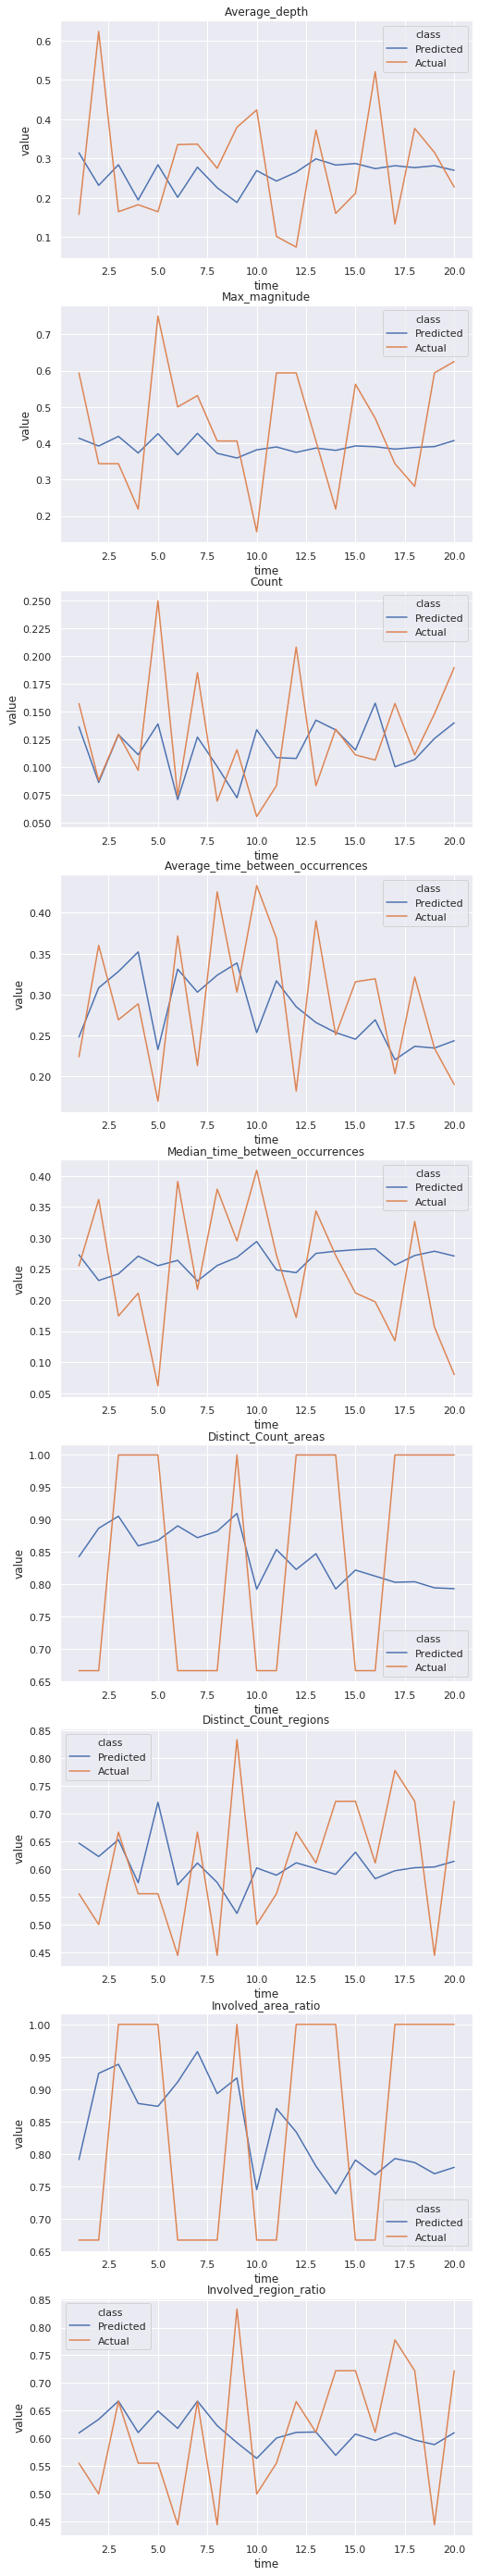

In [0]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(8,50))
mae = plot_monthly_var_forecast(pred_cont, y_test_sc, 20, feat_idx, df3, 2, ax)

In [0]:
for f in range(9):
  print("MAE for: " + df3.iloc[-20:,2:36].columns[feat_idx[f]])
  print("%.4f" % np.mean(mae[f]))

MAE for: Average_depth
0.1279
MAE for: Max_magnitude
0.1372
MAE for: Count
0.0368
MAE for: Average_time_between_occurrences
0.0634
MAE for: Median_time_between_occurrences
0.0845
MAE for: Distinct_Count_areas
0.1727
MAE for: Distinct_Count_regions
0.1030
MAE for: Involved_area_ratio
0.1781
MAE for: Involved_region_ratio
0.0964


#### Long-Short Term Memory network (LSTM) & Gated Recurrent Unit (GRU):

Long Short Term Memory network and Gated Recurrent Unit network have been gaining attention and efforts on solving the vanishing gradient problem of backpropagation process through timesteps that would diminish the weightings on the long term (earlier timesteps) dependencies, and due to the nature that rare large earthquake events often have long cycles for recurrences, LSTM could retain the feature weightings given to each timestep and update them upon iterating through the sequence. It creates a forget gate to convey the values of previous timesteps presented by vectors of hidden cell states (analogous to memories), together with an input gate feeding in the new inputted observation of the current timestep, compiling recurrent flows of information and controlling their weightings to be passed to the output gate by mathematical functions for activations. GRU designates a reset gate and an update gate, while reset gate functions like the forget gate to determine the weightings of past timesteps, update gate does the mathematical computations of input gate and output gate as in LSTM. Comparatively GRU consists of fewer parameters to compute so would be faster in training.

<img src="http://sunlab.org/teaching/cse6250/fall2018/assets/img/gated_rnns.58441fa9.png" width="600"/>
<br>Source:  <i>http://sunlab.org/teaching/cse6250/fall2018/dl/dl-rnn.html#recurrent-neural-networks-2</i>


Same as above, for the monthly-based dataset, the latest 20 months were reserved for testing, on the same 9 target attributes. From the plots of predicted against actual values, the trained stacked layer LSTM and GRU models generally showed agreements to the observed trends of "Average depth" and "Max magnitude", attaining error ranges between 10% to 13%, though still being not robust in capturing noises, but comparatively better than DBN which produced flat predictions close to mean. The prediction error for "Count of earthquakes" was the least, and GRU achieved slightly better result of 3.8% error against 4.6% from LSTM.

The training process on the one-hot encoded vectors of 8-cluster areas and 30-cluster partitioned regions were rather computationally costly due to higher dimensions and complexity, instead of representing the class target by clusters, the latitude and longitude coordinates were directly plugged in as inputs. Stacked LSTM and GRU eliminated the inflated effects of long-term forecasts over 25 timesteps on depth and magnitude as observed in the results of DBN model, while leaving significant errors for latitude and longitude.

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional
from keras.models import Model
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from keras.models import load_model

In [0]:
# 3 dimensions for (observations, timestep, features)
train_X = X_train_sc.reshape(X_train_sc.shape[0], 1, X_train_sc.shape[1])
train_y = y_train_sc.reshape(y_train_sc.shape[0], 1, y_train_sc.shape[1])
test_X = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])
test_y = y_test_sc.reshape(y_test_sc.shape[0], 1, y_test_sc.shape[1])

In [0]:
# For monthly-based aggregated earthquake occurrence predictions (next 20 months):
## define functional API

## stacked LSTM with 1 layer Bi-directional and 1 layer Uni-directional
lstm_input = Input(shape=(1, train_X.shape[2]))
lstm_1 = Bidirectional(LSTM(1200, return_sequences=True))(lstm_input)
lstm_2 = LSTM(600, return_sequences=True)(lstm_1)
lstm_3 = Dense(500, activation='relu')(lstm_2)
lstm_4 = Dense(200, activation='relu')(lstm_3)
lstm_5 = Dense(50, activation='relu')(lstm_4)
lstm_6 = Dense(10, activation='relu')(lstm_5)

output1 = Dense(34)(lstm_5)
output1 = Activation('linear')(output1)

output2 = Dense(5)(lstm_6)
output2 = Activation('tanh')(output2)

adam = optimizers.Adam(lr=0.0001)

lstm_model1 = Model(inputs=lstm_input, outputs=output1)
lstm_model1.compile(loss='mse', optimizer=adam)

lstm_model2 = Model(inputs=lstm_input, outputs=output2)
lstm_model2.compile(loss='mse', optimizer=adam)

In [0]:
fitlstm_34_attr = lstm_model1.fit(train_X, train_y, epochs=100, batch_size=1, shuffle=False)

Epoch 1/100
580/580 [==============================] - 17s 29ms/step - loss: 0.0267
Epoch 2/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0230
Epoch 3/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0224
Epoch 4/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0221
Epoch 5/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0220
Epoch 6/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0213
Epoch 7/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0203
Epoch 8/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0195
Epoch 9/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0188
Epoch 10/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0181
Epoch 11/100
580/580 [==============================] - 12s 21ms/step - loss: 0.0174
Epoch 12/100
580/580 [==============================] - 12s 21ms/step - lo

In [0]:
lstm_model1.save(F"/content/drive/My Drive/Colab Notebooks/lstm_earthquake.h5")
lstm_model1 = load_model(F"/content/drive/My Drive/Colab Notebooks/lstm_earthquake.h5")

Text(0, 0.5, 'loss')

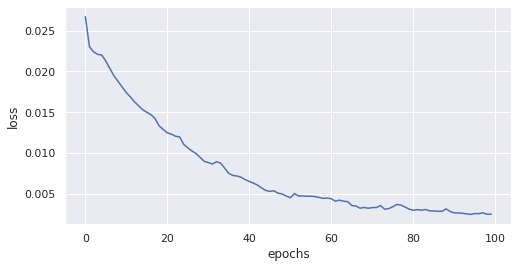

In [0]:
# plot the declining curve in the loss function
seaborn.set(rc={'figure.figsize':(8.0, 4.0)})
plt.plot(fitlstm_34_attr.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [0]:
pred_lstm = []
lag_pred = []

for next_steps in range(20):
  if next_steps == 0:
    pred_values = lstm_model1.predict(test_X[0,:,:].reshape(1, 1, -1), batch_size=1)
    pred_lstm.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])
  else:
    pred_arr = np.array(lag_pred + test_X[next_steps, :, (next_steps*34):].flatten().tolist()).reshape(1, 1, -1)
    pred_values = lstm_model1.predict(pred_arr)
    pred_lstm.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])

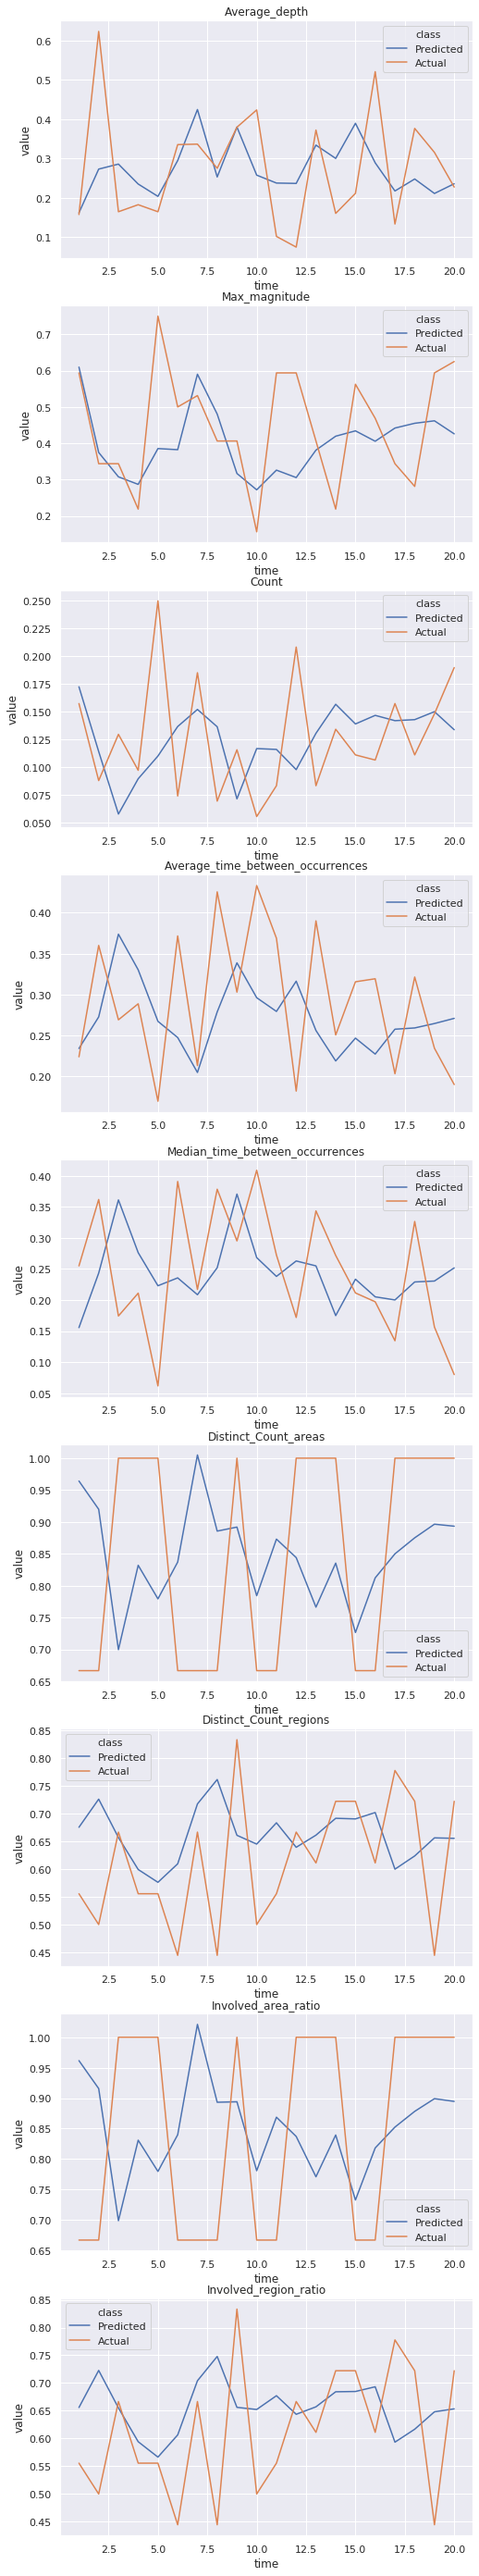

In [0]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(8,50))
mae = plot_monthly_var_forecast(pred_lstm, y_test_sc, 20, feat_idx, df3, 2, ax)

In [0]:
## bidirectional; 3 deep hidden layers
for f in range(9):
  print("MAE for: " + df3.iloc[-20:,2:36].columns[feat_idx[f]])
  print("%.4f" % np.mean(mae[f]))

MAE for: Average_depth
0.1046
MAE for: Max_magnitude
0.1274
MAE for: Count
0.0458
MAE for: Average_time_between_occurrences
0.0786
MAE for: Median_time_between_occurrences
0.0944
MAE for: Distinct_Count_areas
0.1822
MAE for: Distinct_Count_regions
0.1092
MAE for: Involved_area_ratio
0.1829
MAE for: Involved_region_ratio
0.1064


In [0]:
## stacked GRU with 1 layer Bi-directional and 1 layer Uni-directional
gru_input = Input(shape=(1, train_X.shape[2]))
gru_1 = Bidirectional(GRU(1200, return_sequences=True))(gru_input)
gru_2 = GRU(600, return_sequences=True)(gru_1)
gru_3 = Dense(500, activation='relu')(gru_2)
gru_4 = Dense(200, activation='relu')(gru_3)
gru_5 = Dense(50, activation='relu')(gru_4)
gru_6 = Dense(10, activation='relu')(gru_5)

output1 = Dense(34)(gru_5)
output1 = Activation('linear')(output1)

output2 = Dense(5)(gru_6)
output2 = Activation('tanh')(output2)

adam = optimizers.Adam(lr=0.0001)

gru_model1 = Model(inputs=gru_input, outputs=output1)
gru_model1.compile(loss='mse', optimizer=adam)

gru_model2 = Model(inputs=gru_input, outputs=output2)
gru_model2.compile(loss='mse', optimizer=adam)

In [0]:
fitgru_34_attr = gru_model1.fit(train_X, train_y, epochs=100, batch_size=1, shuffle=False)

Epoch 1/100
580/580 [==============================] - 15s 26ms/step - loss: 0.0297
Epoch 2/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0239
Epoch 3/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0224
Epoch 4/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0219
Epoch 5/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0212
Epoch 6/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0202
Epoch 7/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0193
Epoch 8/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0184
Epoch 9/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0175
Epoch 10/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0166
Epoch 11/100
580/580 [==============================] - 10s 18ms/step - loss: 0.0158
Epoch 12/100
580/580 [==============================] - 10s 18ms/step - lo

In [0]:
gru_model1.save(F"/content/drive/My Drive/Colab Notebooks/gru_earthquake.h5")
gru_model1 = load_model(F"/content/drive/My Drive/Colab Notebooks/gru_earthquake.h5")

Text(0, 0.5, 'loss')

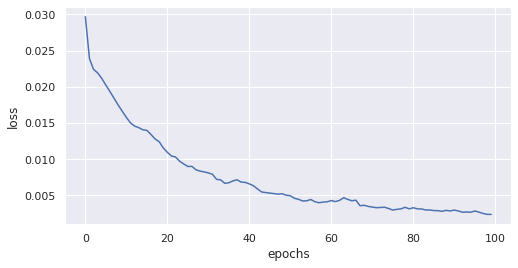

In [0]:
seaborn.set(rc={'figure.figsize':(8.0, 4.0)})
plt.plot(fitgru_34_attr.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [0]:
pred_gru = []
lag_pred = []

for next_steps in range(20):
  if next_steps == 0:
    pred_values = gru_model1.predict(test_X[0,:,:].reshape(1, 1, -1), batch_size=1)
    pred_gru.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])
  else:
    pred_arr = np.array(lag_pred + test_X[next_steps, :, (next_steps*34):].flatten().tolist()).reshape(1, 1, -1)
    pred_values = gru_model1.predict(pred_arr)
    pred_gru.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])

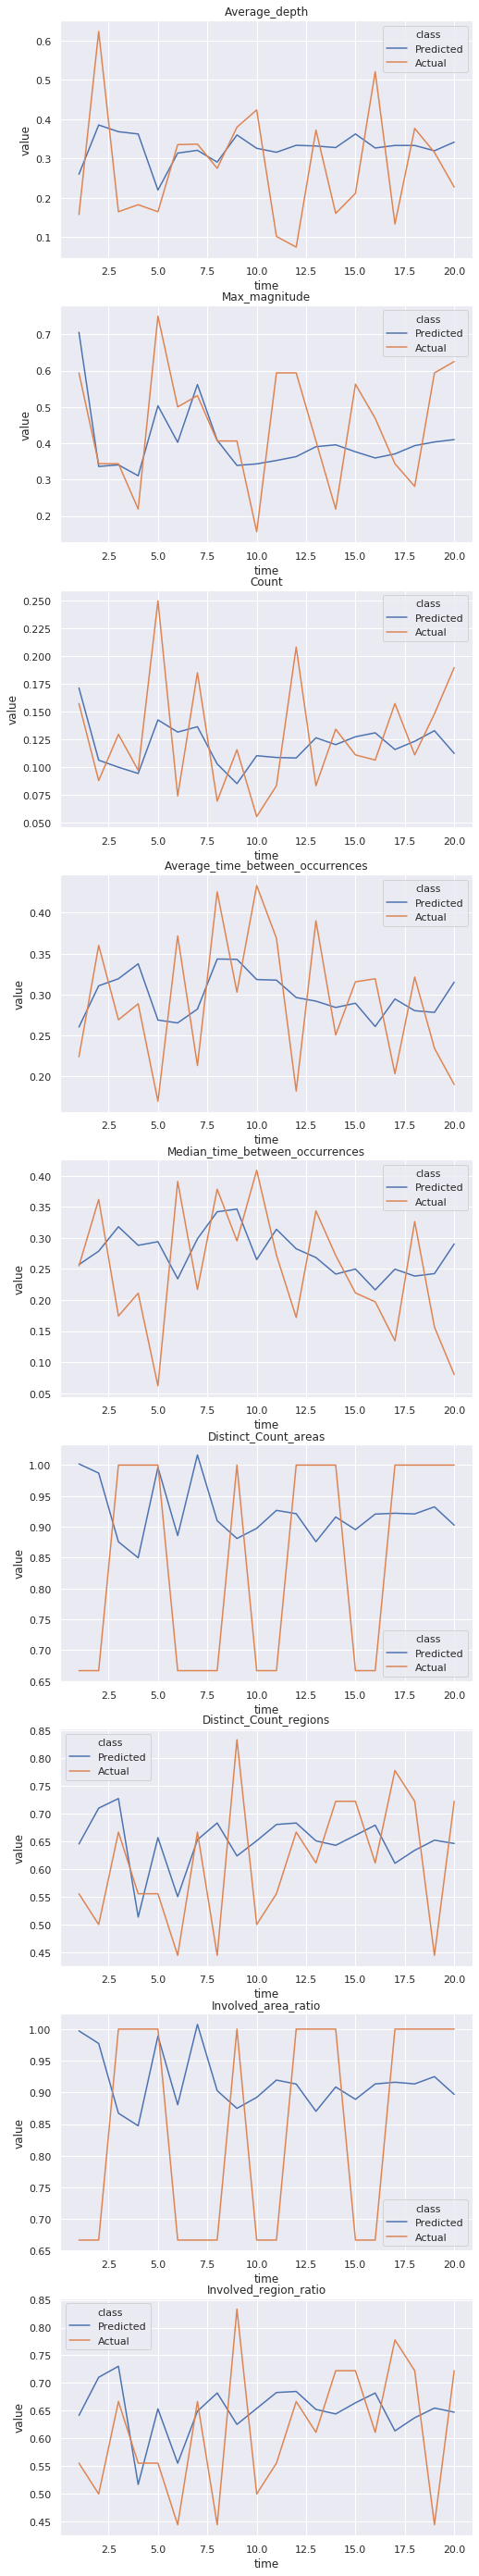

In [0]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(8,50))
mae = plot_monthly_var_forecast(pred_gru, y_test_sc, 20, feat_idx, df3, 2, ax)

In [0]:
for f in range(9):
  print("MAE for: " + df3.iloc[-20:,2:36].columns[feat_idx[f]])
  print("%.4f" % np.mean(mae[f]))

MAE for: Average_depth
0.1167
MAE for: Max_magnitude
0.1174
MAE for: Count
0.0384
MAE for: Average_time_between_occurrences
0.0690
MAE for: Median_time_between_occurrences
0.0912
MAE for: Distinct_Count_areas
0.1724
MAE for: Distinct_Count_regions
0.1076
MAE for: Involved_area_ratio
0.1729
MAE for: Involved_region_ratio
0.1076


In [0]:
# For event-based earthquake single occurrence predictions (next 50 events):
## Loca_Dense_Areas (8-cluster) and Loc_partion_region (30-cluster) classifications are spending long time for training;
##  changes to use continuous Latitude and Longitude coordinates for representation of location features
df4 = df2[['year', 'month', 'day', 'period', 'Latitude', 'Longitude', 'Depth',	'Magnitude', 'Time_diff_prev']]
feature_set_df4 = create_lagged_featue_set(df4, 5, 100, 4)

X_train = feature_set_df4.iloc[101:-50,:]
minmax_scale_df4_x = MinMaxScaler().fit(X_train)
X_train_sc = minmax_scale_df4_x.transform(X_train)
X_test = feature_set_df4.iloc[-50:,:]
X_test_sc = minmax_scale_df4_x.transform(X_test)

minmax_scale_df4_y = MinMaxScaler().fit(df4.iloc[101:-50, 4:9])
y_train_sc = minmax_scale_df4_y.transform(df4.iloc[101:-50, 4:9])
y_test_sc = minmax_scale_df4_y.transform(df4.iloc[-50:, 4:9])

train_X = X_train_sc.reshape(X_train_sc.shape[0], 1, X_train_sc.shape[1])
train_y = y_train_sc.reshape(y_train_sc.shape[0], 1, y_train_sc.shape[1])
test_X = X_test_sc.reshape(X_test_sc.shape[0], 1, X_test_sc.shape[1])
test_y = y_test_sc.reshape(y_test_sc.shape[0], 1, y_test_sc.shape[1])

In [0]:
fitlstm_5_attr = lstm_model2.fit(train_X, train_y, epochs=100, batch_size=25, shuffle=False)

Epoch 1/100
23242/23242 [==============================] - 25s 1ms/step - loss: 0.0427
Epoch 2/100
23242/23242 [==============================] - 19s 820us/step - loss: 0.0414
Epoch 3/100
23242/23242 [==============================] - 19s 832us/step - loss: 0.0412
Epoch 4/100
23242/23242 [==============================] - 19s 815us/step - loss: 0.0410
Epoch 5/100
23242/23242 [==============================] - 19s 833us/step - loss: 0.0408
Epoch 6/100
23242/23242 [==============================] - 19s 832us/step - loss: 0.0407
Epoch 7/100
23242/23242 [==============================] - 18s 779us/step - loss: 0.0405
Epoch 8/100
23242/23242 [==============================] - 17s 745us/step - loss: 0.0403
Epoch 9/100
23242/23242 [==============================] - 18s 769us/step - loss: 0.0400
Epoch 10/100
23242/23242 [==============================] - 18s 764us/step - loss: 0.0397
Epoch 11/100
23242/23242 [==============================] - 17s 751us/step - loss: 0.0392
Epoch 12/100
23242/23

In [0]:
lstm_model2.save(F"/content/drive/My Drive/Colab Notebooks/lstm_earthquake_event.h5")
lstm_model2 = load_model(F"/content/drive/My Drive/Colab Notebooks/lstm_earthquake_event.h5")

Text(0, 0.5, 'loss')

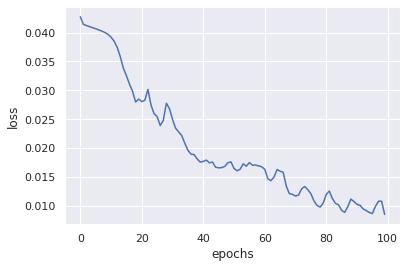

In [0]:
seaborn.set(rc={'figure.figsize':(6.0, 4.0)})
plt.plot(fitlstm_5_attr.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [0]:
pred_lstm = []
lag_pred = []

for next_steps in range(50):
  if next_steps == 0:
    pred_values = lstm_model2.predict(test_X[0,:,:].reshape(1, 1, -1), batch_size=1)
    pred_lstm.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])
  else:
    pred_arr = np.array(lag_pred + test_X[next_steps, :, (next_steps*5):].flatten().tolist()).reshape(1, 1, -1)
    pred_values = lstm_model2.predict(pred_arr)
    pred_lstm.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])

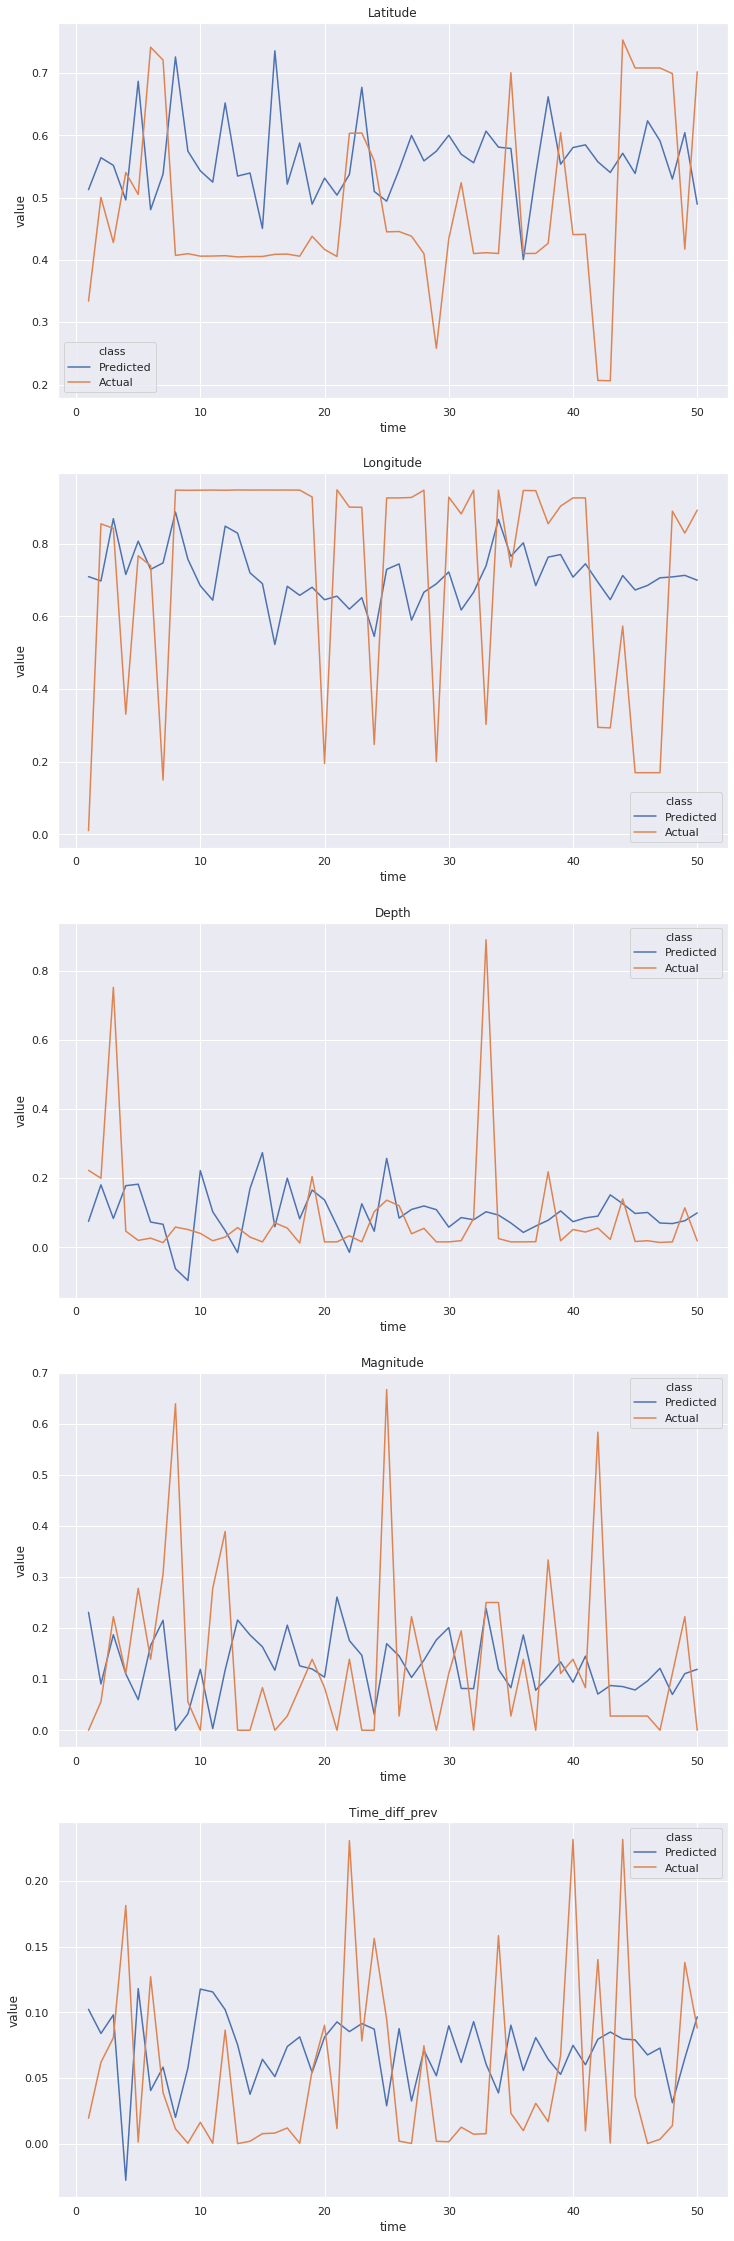

In [0]:
feat_idx = [0,1,2,3,4]
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12,40))
mae = plot_monthly_var_forecast(pred_lstm, y_test_sc, 50, feat_idx, df4, 4, ax)

In [0]:
for f in range(5):
  print("MAE for: " + df4.iloc[-50:,4:9].columns[feat_idx[f]])
  print("%.4f" % np.mean(mae[f]))

MAE for: Latitude
0.1507
MAE for: Longitude
0.2598
MAE for: Depth
0.1047
MAE for: Magnitude
0.1269
MAE for: Time_diff_prev
0.0632


In [0]:
fitgru_5_attr = gru_model2.fit(train_X, train_y, epochs=100, batch_size=25, shuffle=False)

Epoch 1/100
23242/23242 [==============================] - 23s 986us/step - loss: 0.0432
Epoch 2/100
23242/23242 [==============================] - 17s 725us/step - loss: 0.0415
Epoch 3/100
23242/23242 [==============================] - 15s 636us/step - loss: 0.0412
Epoch 4/100
23242/23242 [==============================] - 14s 598us/step - loss: 0.0410
Epoch 5/100
23242/23242 [==============================] - 14s 611us/step - loss: 0.0408
Epoch 6/100
23242/23242 [==============================] - 14s 612us/step - loss: 0.0406
Epoch 7/100
23242/23242 [==============================] - 14s 602us/step - loss: 0.0403
Epoch 8/100
23242/23242 [==============================] - 14s 599us/step - loss: 0.0400
Epoch 9/100
23242/23242 [==============================] - 15s 638us/step - loss: 0.0395
Epoch 10/100
23242/23242 [==============================] - 14s 619us/step - loss: 0.0388
Epoch 11/100
23242/23242 [==============================] - 17s 716us/step - loss: 0.0377
Epoch 12/100
23242/

In [0]:
gru_model2.save(F"/content/drive/My Drive/Colab Notebooks/gru_earthquake_event.h5")
gru_model2 = load_model(F"/content/drive/My Drive/Colab Notebooks/gru_earthquake_event.h5")

Text(0, 0.5, 'loss')

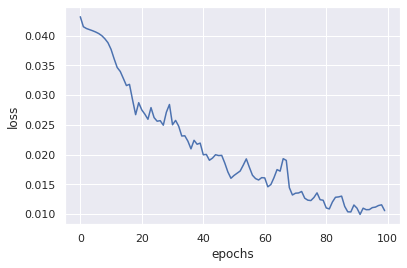

In [0]:
seaborn.set(rc={'figure.figsize':(6.0, 4.0)})
plt.plot(fitgru_5_attr.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [0]:
pred_gru = []
lag_pred = []

for next_steps in range(50):
  if next_steps == 0:
    pred_values = gru_model2.predict(test_X[0,:,:].reshape(1, 1, -1), batch_size=1)
    pred_gru.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])
  else:
    pred_arr = np.array(lag_pred + test_X[next_steps, :, (next_steps*5):].flatten().tolist()).reshape(1, 1, -1)
    pred_values = gru_model2.predict(pred_arr)
    pred_gru.append(pred_values)
    for length in range(len(pred_values.flatten())):
      lag_pred.append(pred_values.flatten()[length])

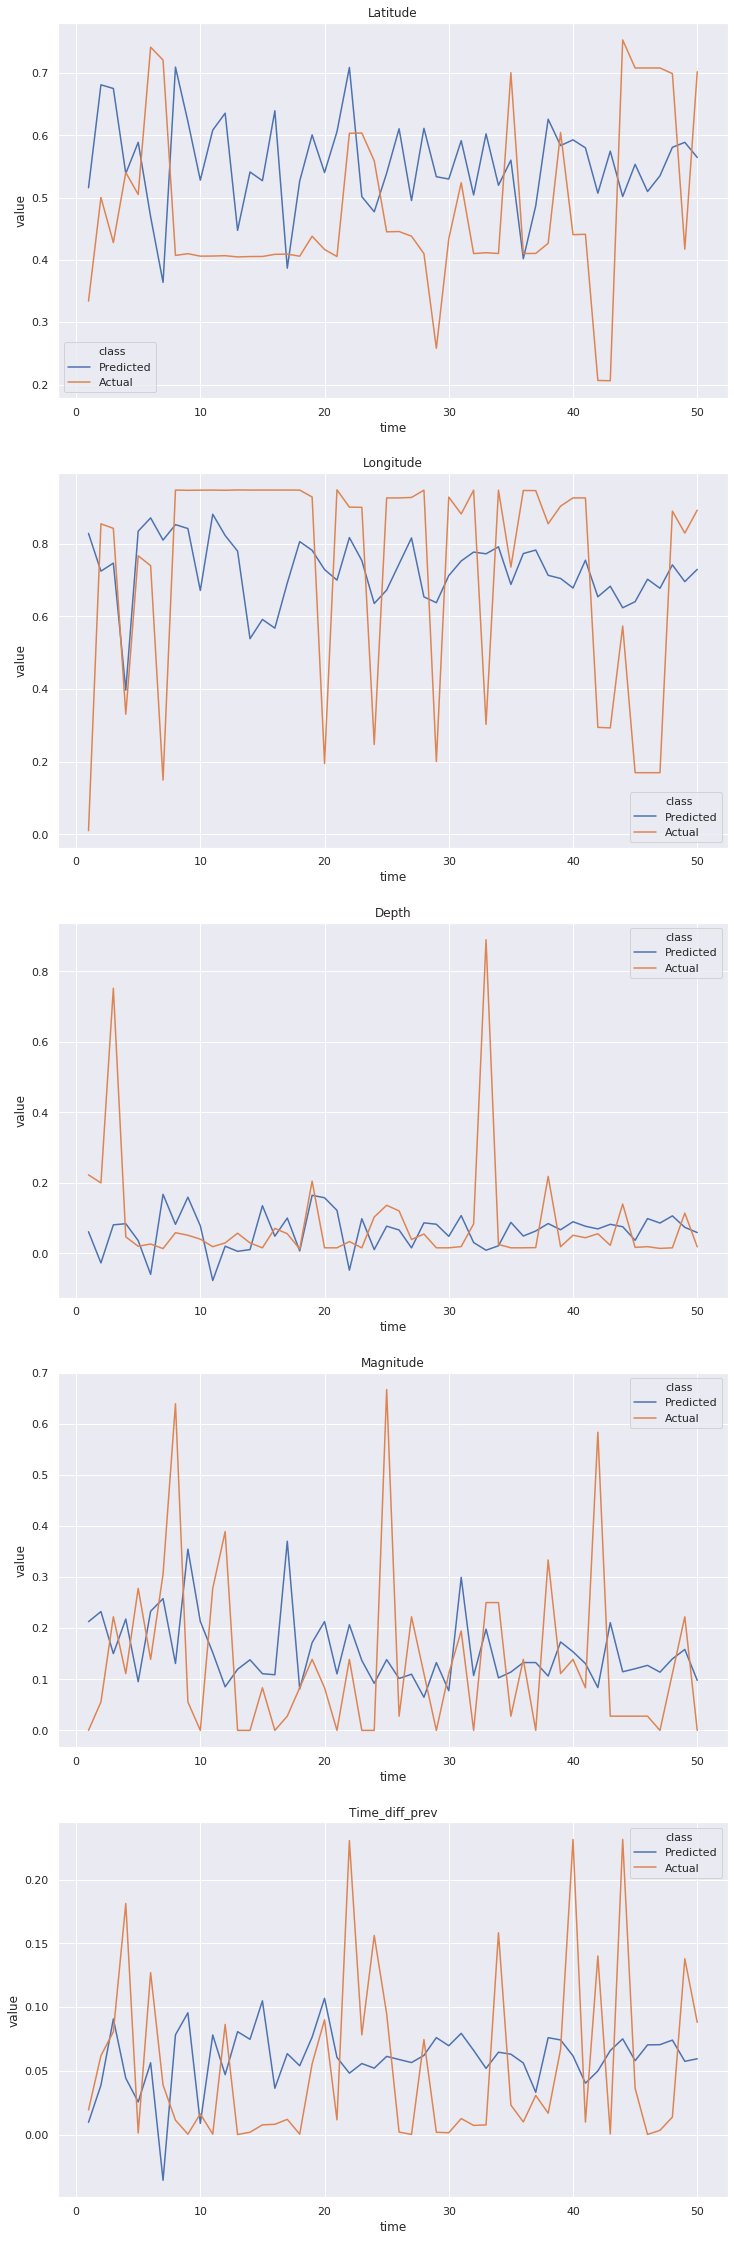

In [0]:
feat_idx = [0,1,2,3,4]
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12,40))
mae = plot_monthly_var_forecast(pred_gru, y_test_sc, 50, feat_idx, df4, 4, ax)

In [0]:
for f in range(5):
  print("MAE for: " + df4.iloc[-50:,4:9].columns[feat_idx[f]])
  print("%.4f" % np.mean(mae[f]))

MAE for: Latitude
0.1560
MAE for: Longitude
0.2445
MAE for: Depth
0.0922
MAE for: Magnitude
0.1366
MAE for: Time_diff_prev
0.0595
